# Data Dictionary

|Attribute|Description
----------|-----------
InvoiceNo| Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode| Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description| Product (item) name. Nominal.
Quantity| The quantities of each product (item) per transaction. Numeric.
InvoiceDate| Invoice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice| Unit price. Numeric, Product price per unit in sterling.
CustomerID| Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country| Country name. Nominal, the name of the country where each customer resides.

# 0.0 Imports

In [1]:
import pandas as pd
import inflection
from src import GeneralUtils  as gu
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import numpy as np
from itertools import product

from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as mt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.preprocessing as pp
import sklearn.manifold as man

import sweetviz
import umap.umap_ as um
from sklearn.decomposition import PCA
import sklearn.mixture as mix
from scipy.cluster.hierarchy import dendrogram, ward, linkage, fcluster
from sklearn.neighbors import NearestNeighbors
from scipy.stats import kstest
#import GeneralUtils as gu

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sklearn
sklearn.__version__

'1.2.2'

In [3]:
plt.style.use('ggplot')
#sns.set_style('darkgrid')

# 0.1 Load Data

In [4]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='ISO-8859-1')

In [5]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  Unnamed: 8  
0   29-Nov-16       2.55     17850.0  United Kingdom         NaN  
1   29-Nov-16       3.39     17850.0  United Kingdom         NaN  
2   29-Nov-16       2.75     17850.0  United Kingdom         NaN  
3   29-Nov-16       3.39     17850.0  United Kingdom         NaN  
4   29-Nov-16       3.39     17850.0  United Kingdom         NaN

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 1.0. Data Description

In [6]:
df_description = df_raw.drop('Unnamed: 8', axis=1)

In [7]:
df_description.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  
0   29-Nov-16       2.55     17850.0  United Kingdom  
1   29-Nov-16       3.39     17850.0  United Kingdom  
2   29-Nov-16       2.75     17850.0  United Kingdom  
3   29-Nov-16       3.39     17850.0  United Kingdom  
4   29-Nov-16       3.39     17850.0  United Kingdom

## 1.1. Renaming Columns

In [8]:
old_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity','InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

df_description.columns = new_cols

In [9]:
df_description['description'] = df_description['description'].str.lower()

In [10]:
df_description.sort_values(['invoice_date', 'description'])

invoice_no stock_code                       description  quantity  \
143414     548701      23007            spaceboy baby gift set         1   
143694     548711      22906   12 message cards with envelopes         2   
144000     548715      22906   12 message cards with envelopes         6   
143573     548708      84461      12 pink hen+chicks in basket         1   
144035     548715      21457  2 picture book eggs easter ducks         6   
...           ...        ...                               ...       ...   
335644     566290      84836       zinc metal heart decoration         2   
335748     566291      84836       zinc metal heart decoration         3   
335588     566290      23153  zinc sweetheart wire letter rack         2   
334150     566233      23145    zinc t-light holder star large        12   
334151     566233      23144   zinc t-light holder stars small        12   

       invoice_date  unit_price  customer_id         country  
143414     1-Apr-17       16.95      17629.0  United Kingdom  
143694     1-Apr-17        1.65      18116.0  United Kingdom  
144000     1-Apr-17        1.65      17758.0  United Kingdom  
143573     1-Apr-17        2.55      13269.0  United Kingdom  
144035     1-Apr-17        1.25      17758.0  United Kingdom  
...             ...         ...          ...             ...  
335644     9-Sep-17        1.25      14456.0  United Kingdom  
335748     9-Sep-17        1.25      12965.0  United Kingdom  
335588     9-Sep-17        3.75      14456.0  United Kingdom  
334150     9-Sep-17        0.95      12635.0         Germany  
334151     9-Sep-17        0.83      12635.0         Germany  

[541909 rows x 8 columns]

## 1.2. Data Dimension

In [11]:
print(f'Number of Rows: {df_description.shape[0]}')
print(f'Number of Columnss: {df_description.shape[1]}')

Number of Rows: 541909
Number of Columnss: 8


## 1.3. Data Types & Missing Values

In [12]:
gu.sum_table(df_description)

Name   dtypes  Uniques  Missing  Missing %
0    invoice_no   object    25900        0       0.00
1    stock_code   object     4070        0       0.00
2   description   object     4206     1454       0.27
3      quantity    int64      722        0       0.00
4  invoice_date   object      305        0       0.00
5    unit_price  float64     1630        0       0.00
6   customer_id  float64     4372   135080      24.93
7       country   object       38        0       0.00

## 1.4.  Handling Missing Values

Checking if there are invoice numbers of elements with missing customer ID in other part of the dataset, so we can fill the missing values.

In [13]:
df_missing = df_description.query('customer_id.isnull()')
df_no_missing = df_description.query('~customer_id.isnull()')

In [14]:
inv_no_missing_customers = df_missing.invoice_no.unique()
stock_code_missing_customers = df_no_missing.stock_code.unique()

In [15]:

df_description.loc[df_description.invoice_date.isin(inv_no_missing_customers)]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

I tried to find invoice numbers of instances with missing customer id in other parts of the dataset to fill in missing values, but none were found.

In [16]:
missing_invoice_no = df_missing[['invoice_no']].drop_duplicates()
missing_invoice_no['customer_id'] = np.arange(19000, 19000+len(missing_invoice_no))

In [17]:
df_description = df_description.merge(missing_invoice_no, on='invoice_no', how='left')

In [18]:
df_description['customer_id'] = df_description['customer_id_x'].combine_first(df_description['customer_id_y'])
df_clean = df_description.drop(columns=['customer_id_x', 'customer_id_y'])

**Negative Quantity That are not cancellations**

In [19]:
df_clean.query("quantity <= 0 & invoice_no.str.isdigit()").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1336 entries, 2406 to 538919
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    1336 non-null   object 
 1   stock_code    1336 non-null   object 
 2   description   474 non-null    object 
 3   quantity      1336 non-null   int64  
 4   invoice_date  1336 non-null   object 
 5   unit_price    1336 non-null   float64
 6   country       1336 non-null   object 
 7   customer_id   1336 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 93.9+ KB


## 1.5. Fixing Data Types

In [20]:
df_clean.invoice_date = pd.to_datetime(df_clean.invoice_date)
df_clean.customer_id = df_clean.customer_id.astype(int)

In [21]:
df_clean.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   white hanging heart t-light holder         6   
1     536365      71053                  white metal lantern         6   
2     536365     84406B       cream cupid hearts coat hanger         8   
3     536365     84029G  knitted union flag hot water bottle         6   
4     536365     84029E       red woolly hottie white heart.         6   

  invoice_date  unit_price         country  customer_id  
0   2016-11-29        2.55  United Kingdom        17850  
1   2016-11-29        3.39  United Kingdom        17850  
2   2016-11-29        2.75  United Kingdom        17850  
3   2016-11-29        3.39  United Kingdom        17850  
4   2016-11-29        3.39  United Kingdom        17850

In [22]:
df_clean.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.6. Descriptive Statistics

### 1.6.1 Numerical Attributes

In [23]:
num_att = df_clean.select_dtypes(include=['float64', 'int64'])
cat_att = df_clean.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

In [24]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'var', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

Attributes       min      max      range      mean  median           var  \
0    quantity -80995.00  80995.0  161990.00  9.552250    3.00  47559.391409   
1  unit_price -11062.06  38970.0   50032.06  4.611114    2.08   9362.469164   

          std        skew       kurtosis  
0  218.081158   -0.264076  119769.160031  
1   96.759853  186.506972   59005.719097

In [25]:
df_clean.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99, 0.997])[['quantity', 'unit_price']].T

count      mean         std       min    1%    5%   10%   20%  \
quantity    541909.0  9.552250  218.081158 -80995.00 -2.00  1.00  1.00  1.00   
unit_price  541909.0  4.611114   96.759853 -11062.06  0.19  0.42  0.63  0.85   

             50%    80%    90%    95%    99%   99.7%      max  
quantity    3.00  12.00  24.00  29.00  100.0  240.00  80995.0  
unit_price  2.08   4.95   7.95   9.95   18.0   39.95  38970.0

In [26]:
df_clean.sort_values('quantity').head()

invoice_no stock_code                          description  quantity  \
540422    C581484      23843          paper craft , little birdie    -80995   
61624     C541433      23166       medium ceramic top storage jar    -74215   
225529     556690      23005         printing smudges/thrown away     -9600   
225530     556691      23005         printing smudges/thrown away     -9600   
4287      C536757      84347  rotating silver angels t-light hldr     -9360   

       invoice_date  unit_price         country  customer_id  
540422   2017-12-07        2.08  United Kingdom        16446  
61624    2017-01-16        1.04  United Kingdom        12346  
225529   2017-06-12        0.00  United Kingdom        20914  
225530   2017-06-12        0.00  United Kingdom        20915  
4287     2016-11-30        0.03  United Kingdom        15838

In [27]:
df_clean.query('customer_id == 20914')

invoice_no stock_code                   description  quantity  \
225529     556690      23005  printing smudges/thrown away     -9600   

       invoice_date  unit_price         country  customer_id  
225529   2017-06-12         0.0  United Kingdom        20914

There are some weird values in this dataset. We know that C stands for cancellation in the invoice code, so we expect to see a negative quantity in these instances. But we can observe some samples that aren't cancellations with a negative quantity. We will give a better look at this in the filter variables section.

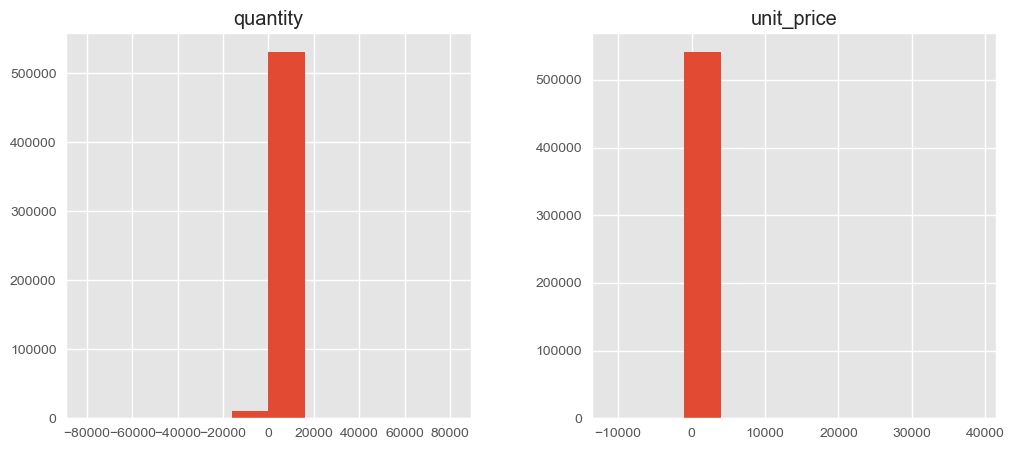

In [28]:
df_clean.drop(columns=['invoice_date', 'customer_id']).hist(figsize=(12, 5));

### <font color='red'> 1.6.2  Further Analysis needed </font>

Quantity with negative values -> What to do with cancellations.

Unit price < 0 -> error? remove these values?


### 1.6.1 Categorical Attributes

**Invoice Number with at least one string**

In [29]:
# df_description.inoice_no.astype(int)
letter_invoices = df_clean.loc[df_description.invoice_no.str.contains('C')]

print('Total Number of Cancelation invoices:', len(letter_invoices))
print('Total Number of Negative quantites:', len(letter_invoices.query('quantity < 0')))

Total Number of Cancelation invoices: 9288
Total Number of Negative quantites: 9288


**Stock codes with at least one string**

In [30]:
df_clean.loc[~df_clean.stock_code.str.isdigit()].head()

invoice_no stock_code                          description  quantity  \
0      536365     85123A   white hanging heart t-light holder         6   
2      536365     84406B       cream cupid hearts coat hanger         8   
3      536365     84029G  knitted union flag hot water bottle         6   
4      536365     84029E       red woolly hottie white heart.         6   
45     536370       POST                              postage         3   

   invoice_date  unit_price         country  customer_id  
0    2016-11-29        2.55  United Kingdom        17850  
2    2016-11-29        2.75  United Kingdom        17850  
3    2016-11-29        3.39  United Kingdom        17850  
4    2016-11-29        3.39  United Kingdom        17850  
45   2016-11-29       18.00          France        12583

**Stock codes that are only strings**

In [31]:
df_clean.loc[df_clean.stock_code.str.isalpha()].stock_code.value_counts()
# Remove stovk_code in [POST, M, D, DOT, CRUK, PADS, AMAZONFEE ,CRUK, DCGSSGIRL, DCGSSBOY, PADS, B, m]

POST         1256
DOT           710
M             571
D              77
S              63
AMAZONFEE      34
CRUK           16
DCGSSGIRL      13
DCGSSBOY       11
PADS            4
B               3
m               1
Name: stock_code, dtype: int64

**Countries**

In [32]:
df_clean.groupby('country').nunique()[['customer_id']].reset_index().sort_values('customer_id', ascending=False)

country  customer_id
36        United Kingdom         7587
14               Germany           95
13                France           90
10                  EIRE           44
31                 Spain           31
3                Belgium           25
33           Switzerland           24
27              Portugal           20
19                 Italy           15
16             Hong Kong           15
12               Finland           12
1                Austria           11
25                Norway           10
24           Netherlands            9
0              Australia            9
37           Unspecified            9
9                Denmark            9
6        Channel Islands            9
7                 Cyprus            8
32                Sweden            8
20                 Japan            8
18                Israel            7
26                Poland            6
5                 Canada            4
34                   USA            4
2                Bahrain            4
15                Greece            4
23                 Malta            2
35  United Arab Emirates            2
8         Czech Republic            1
22             Lithuania            1
11    European Community            1
21               Lebanon            1
28                   RSA            1
29          Saudi Arabia            1
30             Singapore            1
17               Iceland            1
4                 Brazil            1

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 2.0. Variables Filtering

In [33]:
df_filter = df_clean.copy()
columns = ['invoice_no', 'quantity', 'invoice_date', 'unit_price', 'customer_id']

## 2.1. Numerical

In [34]:
df_filter.query("(quantity <= 0 & invoice_no.str.isdigit())").sort_values('quantity').head()

invoice_no stock_code                   description  quantity  \
225530     556691      23005  printing smudges/thrown away     -9600   
225529     556690      23005  printing smudges/thrown away     -9600   
225528     556687      23003  printing smudges/thrown away     -9058   
115818     546152     72140F                    throw away     -5368   
431381     573596     79323W        unsaleable, destroyed.     -4830   

       invoice_date  unit_price         country  customer_id  
225530   2017-06-12         0.0  United Kingdom        20915  
225529   2017-06-12         0.0  United Kingdom        20914  
225528   2017-06-12         0.0  United Kingdom        20913  
115818   2017-03-07         0.0  United Kingdom        19837  
431381   2017-10-29         0.0  United Kingdom        22229

By the description of those items, it seems like they are some mistakes or a problem with the product. We will remove this values from the data

In [35]:
df_filter = df_filter.query("~(quantity <= 0 & invoice_no.str.isdigit())")

In [36]:
desc = df_filter[['customer_id', 'description', 'quantity', 'unit_price']].query('unit_price < 0.04').description.unique()#.sort_values('unit_price', ascending=False).head(10)
items_with_multiple_unit_prices = (df_filter.groupby('description').nunique()[['unit_price']] > 1).index

df_filter.loc[(df_filter['description'].isin(items_with_multiple_unit_prices)) & (df_filter['description'].isin(desc)) ].sort_values(['description', 'unit_price',]).head(10)

invoice_no stock_code                  description  quantity  \
279324     561284      22167   oval wall mirror diamante          1   
174137     551747      22167   oval wall mirror diamante         24   
60112      541421      22167   oval wall mirror diamante          2   
65218      541695      22167   oval wall mirror diamante          2   
66845      541827      22167   oval wall mirror diamante          1   
68670      541871      22167   oval wall mirror diamante          1   
73262      542344      22167   oval wall mirror diamante          1   
75108      542541      22167   oval wall mirror diamante          1   
76246      542622      22167   oval wall mirror diamante          1   
79928      543013      22167   oval wall mirror diamante          1   

       invoice_date  unit_price         country  customer_id  
279324   2017-07-24        0.00  United Kingdom        16818  
174137   2017-05-02        3.95  United Kingdom        14298  
60112    2017-01-15        8.29  United Kingdom        19414  
65218    2017-01-18        8.29  United Kingdom        19443  
66845    2017-01-19        8.29  United Kingdom        19451  
68670    2017-01-22        8.29  United Kingdom        19455  
73262    2017-01-25        8.29  United Kingdom        19477  
75108    2017-01-26        8.29  United Kingdom        19514  
76246    2017-01-29        8.29  United Kingdom        19552  
79928    2017-01-31        8.29  United Kingdom        19578

In [37]:
df_filter = df_filter.query('unit_price >= 0.004')

idea for next cycle: compute the average unit price, or the mode, for each product (without the zero values) and fill the extremly low values with it.

## 2.2. Categorical

In [38]:
# removing stock_codes that are only letters
df_filter = df_filter.query("~stock_code.isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])")

# removing European Community and Unspecified
df_filter = df_filter.query("~country.isin(['European Community', 'Unspecified'])")

country_dict = {'EIRE': 'Ireland', 'RSA': 'South Africa', 'USA': 'United States', 'Channel Islands': 'United Kingdom'}

countries_to_modify = ['USA', 'Channel Islands', 'RSA', 'EIRE']

df_filter.country = df_filter.country.apply(lambda x: country_dict[x] if x in countries_to_modify else x)

In [39]:
# description
print(f'Removed data: {1 - (df_filter.shape[0]/df_clean.shape[0]):.3%}')
print(f'Number of Elements Removed: {df_clean.shape[0] - df_filter.shape[0]}')

Removed data: 1.064%
Number of Elements Removed: 5765


In [40]:
df_filter.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

In [41]:
print('Number of rows Cancelation:', df_filter.query("quantity < 0 or invoice_no.str.contains('C')").shape[0])
print('Number of rows Transaction:', df_filter.query('quantity > 0').shape[0])

Number of rows Cancelation: 8730
Number of rows Transaction: 527414


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 3.0. Feature Engineering

In [42]:
# Moving Average
# Quantidade de compras por mês, antes do dia 15 e depois do dia 15
# Average Financial
# Basket SIze Price

In [43]:
df_feature = df_filter.copy()
df_feature_cancelation = df_filter.query("quantity < 0 or invoice_no.str.contains('C')").copy()
df_feature_transaction = df_filter.query('quantity > 0').copy()

In [44]:
countries_lat_long = pd.read_csv('../data/external/countries.csv')
countries_lat_long.head()

country   latitude  longitude                  name
0      AD  42.546245   1.601554               Andorra
1      AE  23.424076  53.847818  United Arab Emirates
2      AF  33.939110  67.709953           Afghanistan
3      AG  17.060816 -61.796428   Antigua and Barbuda
4      AI  18.220554 -63.068615              Anguilla

In [45]:
countries_lat_long.rename(columns={'name': 'country', 'country': 'code'}, inplace=True)

**Recency, Frequency and Monetary**

In [46]:
df_feature['gross_revenue'] = df_feature.quantity * df_feature.unit_price


# Recency
diff = df_filter.invoice_date.max() - df_feature_transaction.groupby('customer_id').max()['invoice_date']
recency = pd.DataFrame(diff).reset_index().rename(columns={'invoice_date': 'recency'})

recency['recency'] = recency['recency'].dt.days
df_feature = df_feature.merge((recency), how='left', on='customer_id')


# Frequency
min_date = df_feature.invoice_date.min()
max_date = df_feature.invoice_date.max()
aux = df_feature_transaction.groupby('customer_id').agg( max_ = ('invoice_date', 'max'), 
                                       min_ = ('invoice_date', 'min'),
                                       #days_ = ('invoice_date', lambda x: (max_date - min_date).days + 1),
                                       days_ = ('invoice_date', lambda x: (x.max() - x.min()).days + 1),
                                       buy_ = ('invoice_no', 'nunique'),
                                      ).reset_index()

aux['frequency'] = aux.buy_/aux.days_
aux['frequency'] = aux.buy_/aux.days_

df_feature = df_feature.merge(aux[['customer_id', 'frequency']], on='customer_id', how='left')

# Monetary
monetary = df_feature.groupby('customer_id').sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'monetary'})
df_feature = df_feature.merge((monetary), how='left', on='customer_id')

In [47]:
#min_date = df_feature.invoice_date.min()
#max_date = df_feature.invoice_date.max()
#aux = aux = df_feature_transaction.groupby('customer_id').agg( max_ = ('invoice_date', 'max'), 
#                                       min_ = ('invoice_date', 'min'),
#                                       days_ = ('invoice_date', lambda x: (x.max() - x.min()).days + 1),
#                                       buy_ = ('invoice_no', 'nunique'),
#                                      ).reset_index()
#
#aux['frequency'] = aux.buy_/aux.days_
##
#aux['frequency'] = aux.buy_/aux.days_
#aux.sort_values('frequency')

**Number of transactions, Variety, Average Ticket and Average Basket Size**

In [48]:
# Transactions
transactions = df_feature.groupby('customer_id').nunique()[['invoice_no']].reset_index().rename(columns={'invoice_no': 'transactions'})
df_feature = df_feature.merge((transactions), how='left', on='customer_id')

# Average Ticket
avg_ticket = df_feature.groupby(['customer_id', 'invoice_no']).sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'avg_ticket'}).groupby('customer_id').mean(numeric_only=True).reset_index()
df_feature = df_feature.merge((avg_ticket), how='left', on='customer_id')

# Product Variety
product_variety = df_feature_transaction.groupby('customer_id').nunique()[['description']].reset_index().rename(columns={'description': 'product_variety'})
df_feature = df_feature.merge((product_variety), how='left', on='customer_id')

# Average Basket Size 
avg_basket = df_feature[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).sum()\
                                                                                                                .reset_index().groupby('customer_id').mean(numeric_only=True)\
                                                                                                                .reset_index().rename(columns={'quantity': 'avg_basket'})
df_feature = df_feature.merge((avg_basket), how='left', on='customer_id')


# Average Basket Variety Size
avg_basket_var = df_feature_transaction[['customer_id', 'invoice_no', 'stock_code']].groupby(['customer_id', 'invoice_no']).nunique()\
                                                                                                                .reset_index().groupby('customer_id').mean(numeric_only=True)\
                                                                                                                .reset_index().rename(columns={'stock_code': 'avg_basket_variety'})
df_feature = df_feature.merge(avg_basket_var, how='left', on='customer_id')

**Average Recency, Total Cancelltions, Quantity**

In [49]:
df_aux = df_feature_transaction[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'])

df_aux['previous_date'] = df_aux.shift(periods=1).sort_values(['customer_id', 'invoice_date'])['invoice_date']
df_aux['previous_customer_id'] = df_aux.shift(periods=1).sort_values(['customer_id', 'invoice_date'])['customer_id']

df_aux['days']  = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if float(x['customer_id']) == x['previous_customer_id'] else np.nan, axis=1)
df_aux = df_aux.dropna()

df_recency_avg = df_aux.groupby('customer_id').mean(numeric_only=True).reset_index()[['customer_id', 'days']].rename(columns={'days': 'avg_recency'})
df_feature = df_feature.merge(df_recency_avg, on='customer_id', how='left')


cancelations = df_feature_cancelation[['customer_id', 'quantity']].groupby('customer_id').apply(lambda c: c.abs().sum())[['quantity']].reset_index().rename(columns={'quantity': 'number_of_cancelations'})
df_feature = df_feature.merge(cancelations, how='left', on='customer_id')


# Total Quantity
quantity = df_feature.groupby('customer_id').sum(numeric_only=True).quantity.reset_index().rename(columns={'quantity': 'total_quantity'})
df_feature = df_feature.merge(quantity, how='left', on='customer_id')

df_feature.isnull().sum()

invoice_no                     0
stock_code                     0
description                    0
quantity                       0
invoice_date                   0
unit_price                     0
country                        0
customer_id                    0
gross_revenue                  0
recency                      275
frequency                    275
monetary                       0
transactions                   0
avg_ticket                     0
product_variety              275
avg_basket                     0
avg_basket_variety           275
avg_recency               168440
number_of_cancelations    292831
total_quantity                 0
dtype: int64

Some customers only have cancellations, they need to be removed.

In [50]:
columns = ['customer_id', 'country', 'recency', 'frequency', 'monetary', 'transactions', 'avg_recency','total_quantity', 'avg_ticket', 'product_variety', 'avg_basket', 'avg_basket_variety', 'number_of_cancelations']
df_customers = df_feature.drop_duplicates('customer_id').copy()[columns]
df_customers.head()

customer_id         country  recency  frequency  monetary  transactions  \
0         17850  United Kingdom    372.0  17.000000   5288.63            35   
9         13047  United Kingdom     56.0   0.028302   3089.10            16   
26        12583          France      2.0   0.040323   6629.34            17   
45        13748  United Kingdom     95.0   0.017921    948.25             5   
64        15100  United Kingdom    333.0   0.073171    635.10             6   

    avg_recency  total_quantity  avg_ticket  product_variety  avg_basket  \
0      1.000000            1693  151.103714             21.0   48.371429   
9     52.833333            1355  193.068750            105.0   84.687500   
26    26.500000            4978  389.961176            116.0  292.823529   
45    92.666667             439  189.650000             24.0   87.800000   
64    20.000000              58  105.850000              1.0    9.666667   

    avg_basket_variety  number_of_cancelations  
0             8.735294                    40.0  
9            19.000000                    35.0  
26           15.466667                    50.0  
45            5.600000                     NaN  
64            1.000000                    22.0

In [51]:
df_customers.isnull().sum()

customer_id                  0
country                      0
recency                     91
frequency                   91
monetary                     0
transactions                 0
avg_recency               3013
total_quantity               0
avg_ticket                   0
product_variety             91
avg_basket                   0
avg_basket_variety          91
number_of_cancelations    4190
dtype: int64

The number of cancelations with null values are customers with no cancellations.

Customers with avg_recency with null values only have one purchase. For this cycle, I'll remove these customer.

I want to focus on customers who have made purchases. Therefore I will remove those with a negative monetary value, which may mean they have more canceled orders than purchases.

In [52]:
# fill null values for number of cancellations
df_customers['number_of_cancelations'] = df_customers['number_of_cancelations'].fillna(0)

In [53]:
df_customers_clean = df_customers.query('(monetary > 0 and ~avg_recency.isnull())')
print('Items Removed:', df_customers.shape[0] - df_customers_clean.shape[0])

Items Removed: 3015


In [54]:
df_customers_clean.isnull().sum()

customer_id               0
country                   0
recency                   0
frequency                 0
monetary                  0
transactions              0
avg_recency               0
total_quantity            0
avg_ticket                0
product_variety           0
avg_basket                0
avg_basket_variety        0
number_of_cancelations    0
dtype: int64

After filtering the dataset, I will add the longitude and latitude for the countries.

In [55]:
df_customers_clean = df_customers_clean.merge(countries_lat_long, on='country', how='left')

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 4.0. Exploratory Data Analysis

In [56]:
df_eda = df_customers_clean.copy().drop(columns='code', axis=0)

## 4.1 Univariate Analysis

In [57]:
import warnings
warnings.filterwarnings('ignore')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



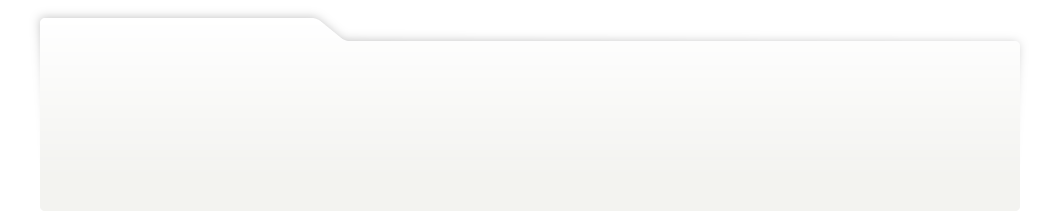
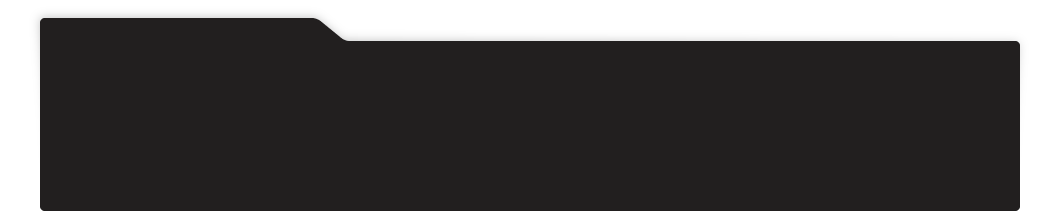
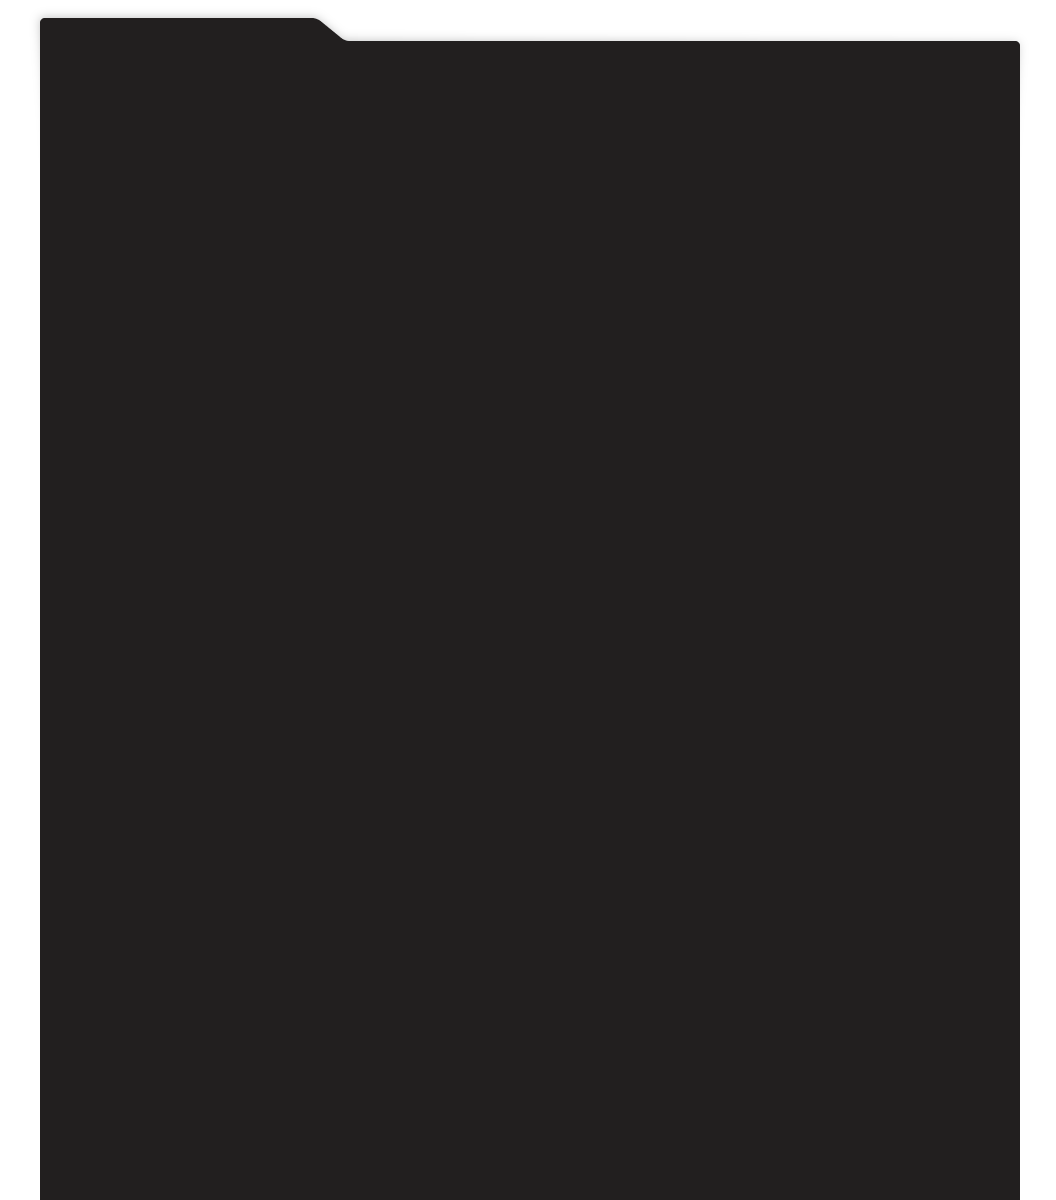
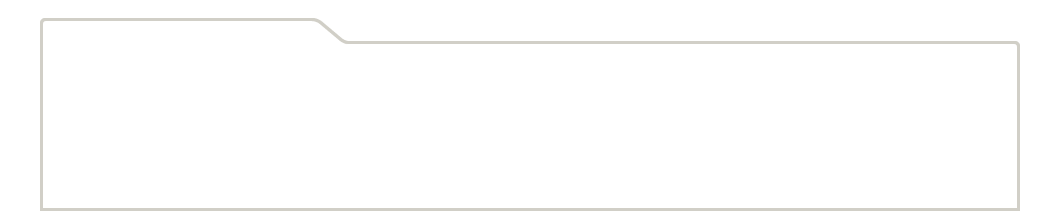
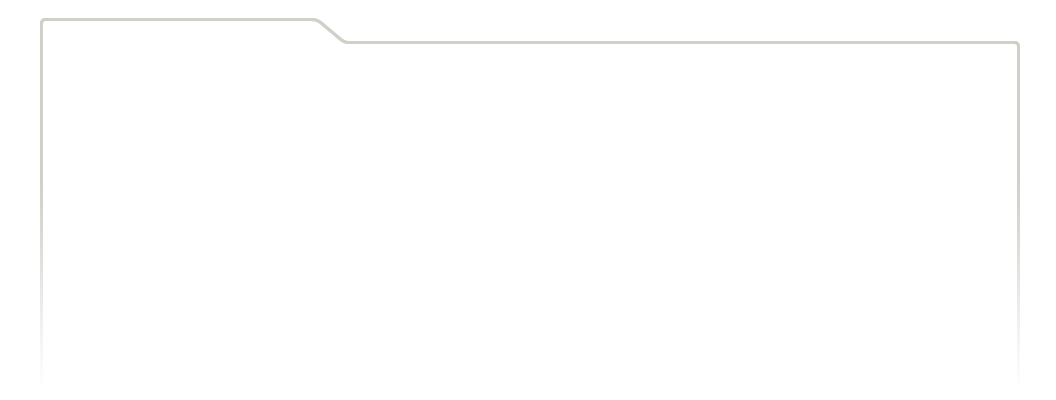
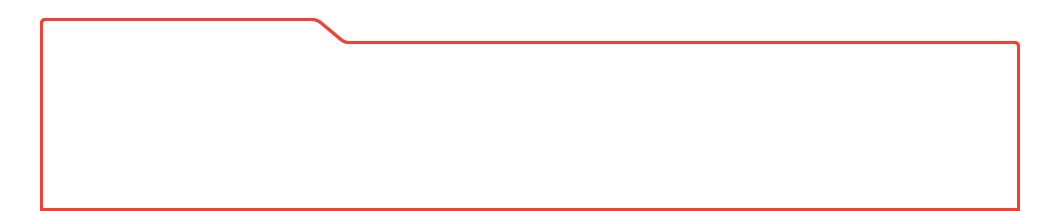
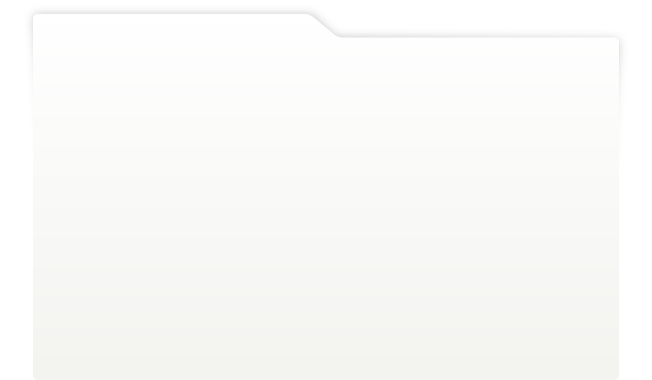
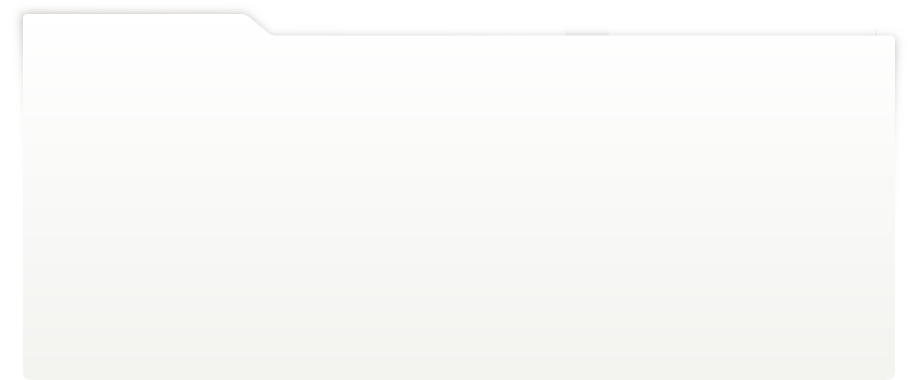
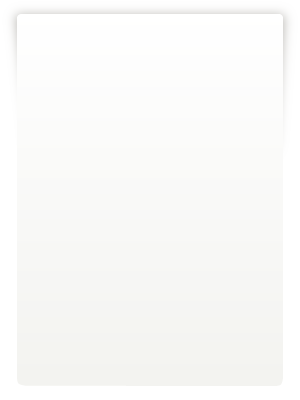
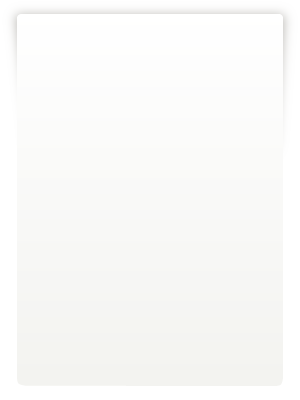
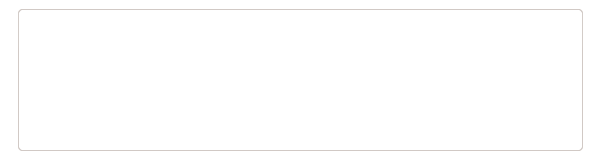
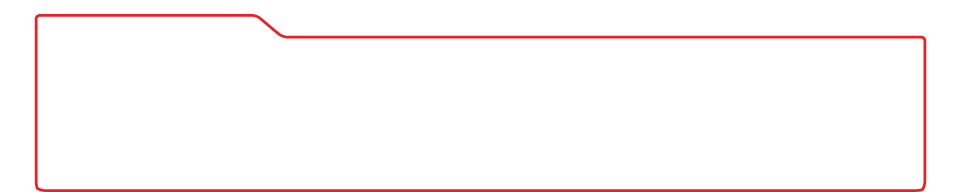
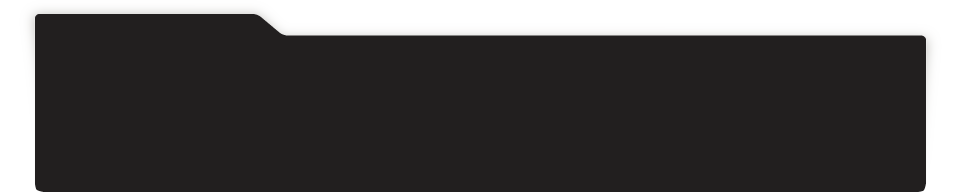
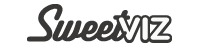
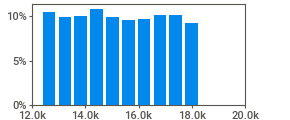
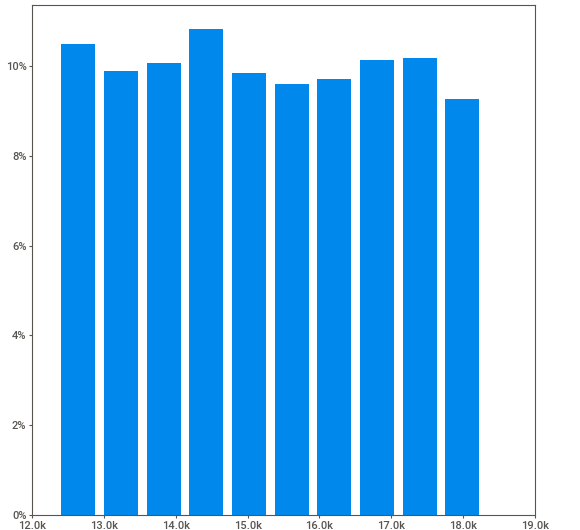
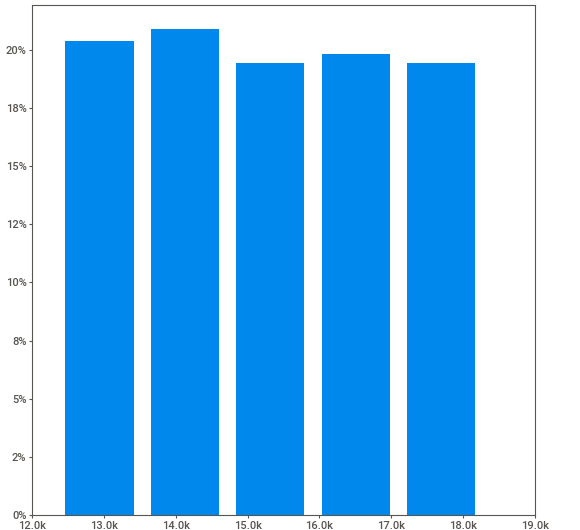
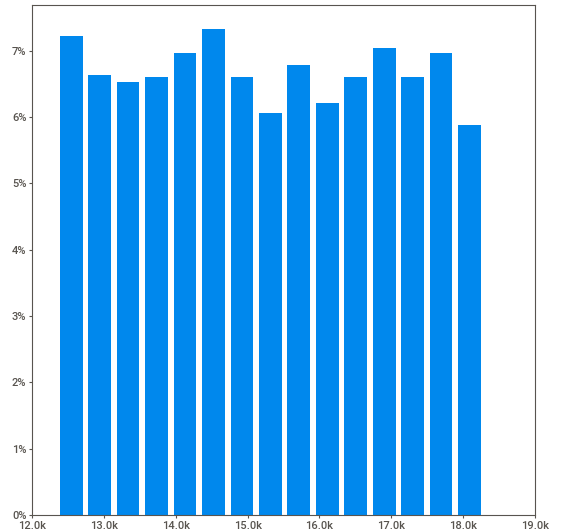
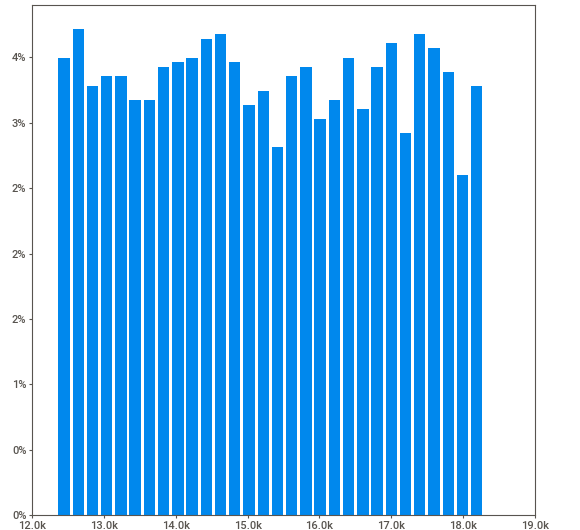
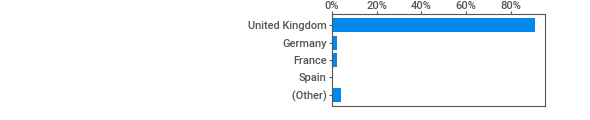
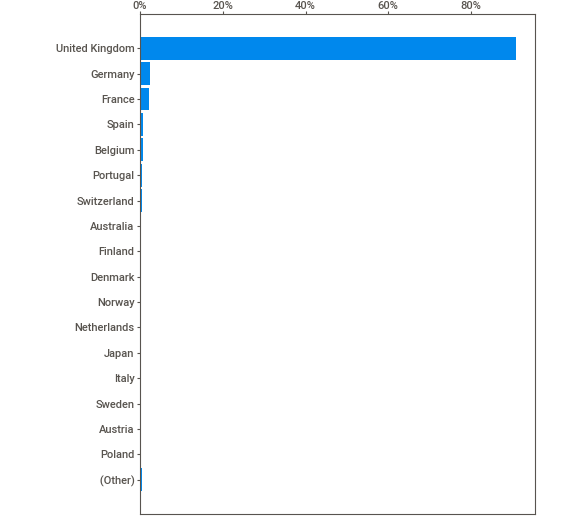
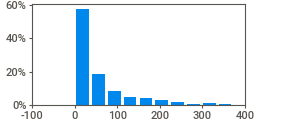
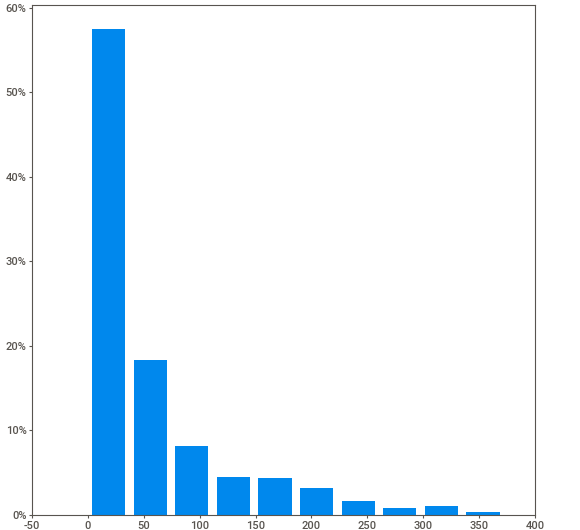
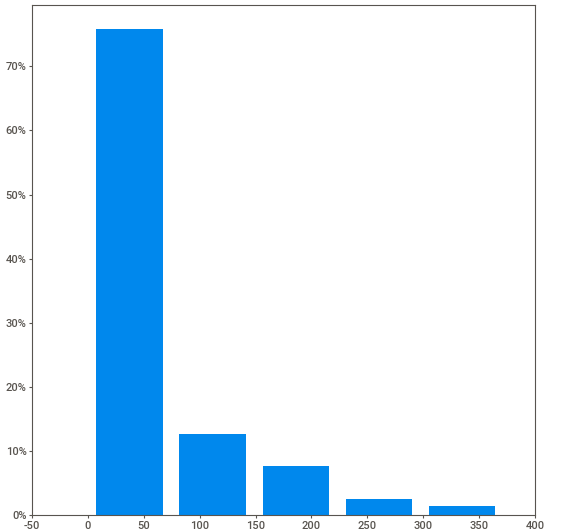
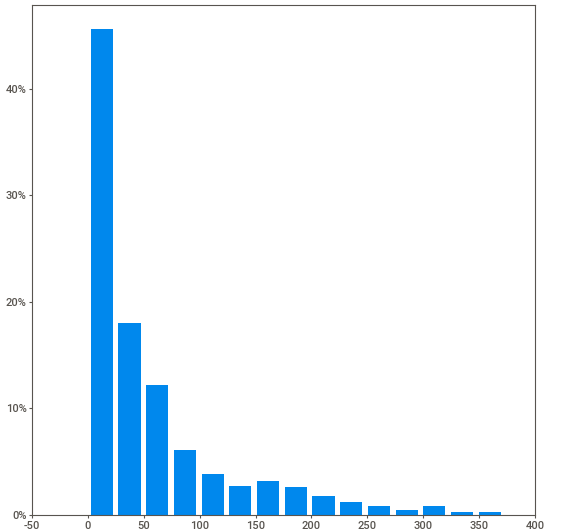
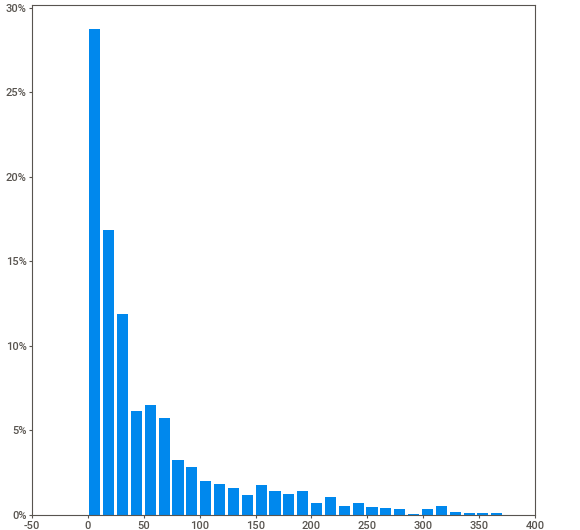
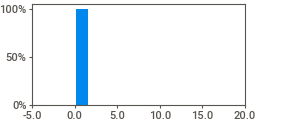
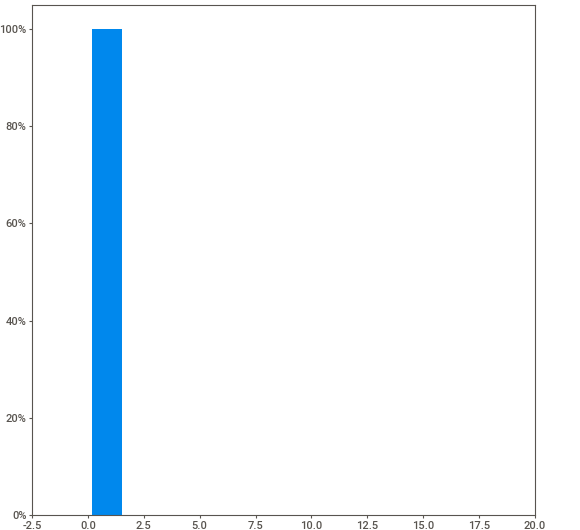
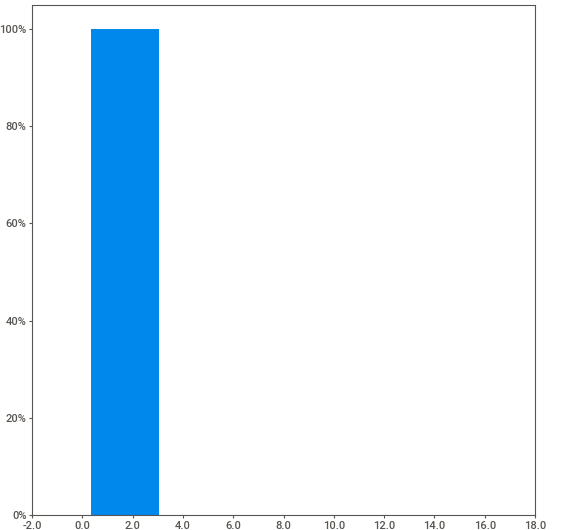
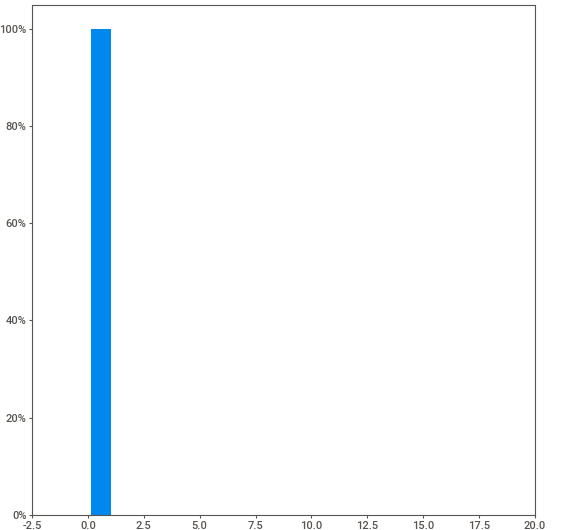
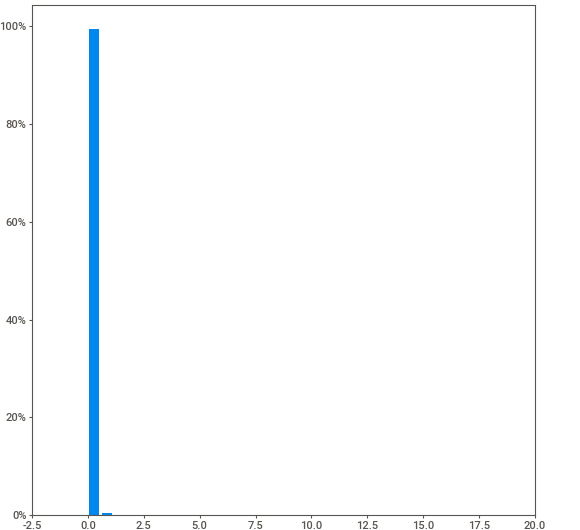
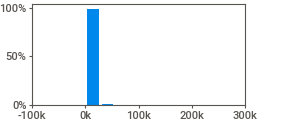
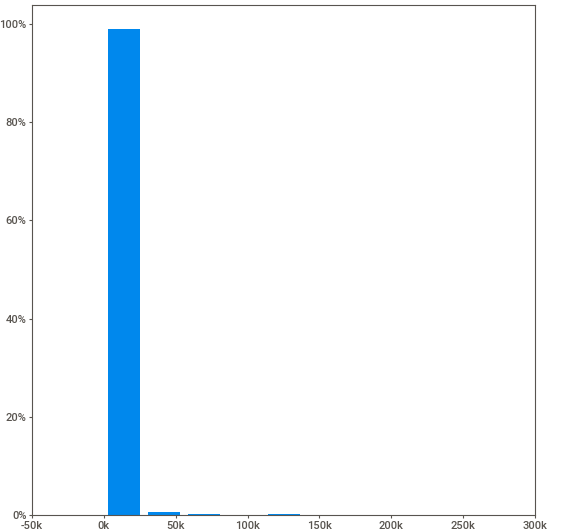
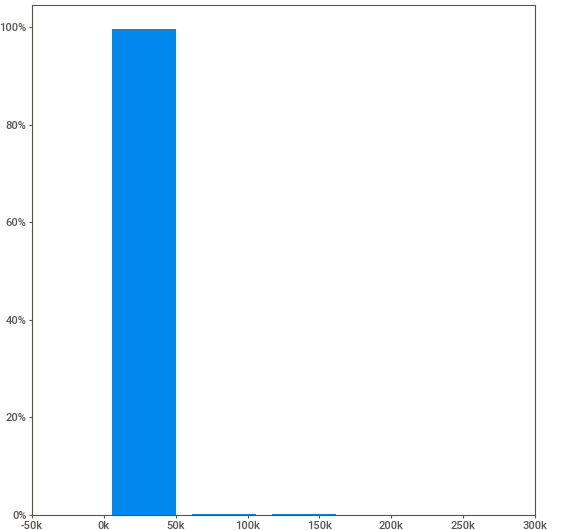
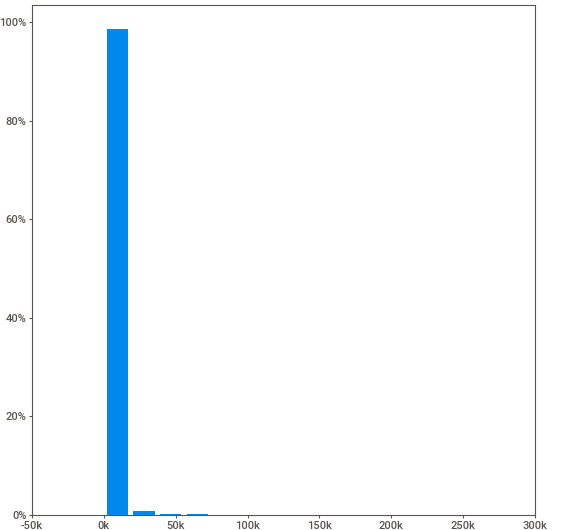
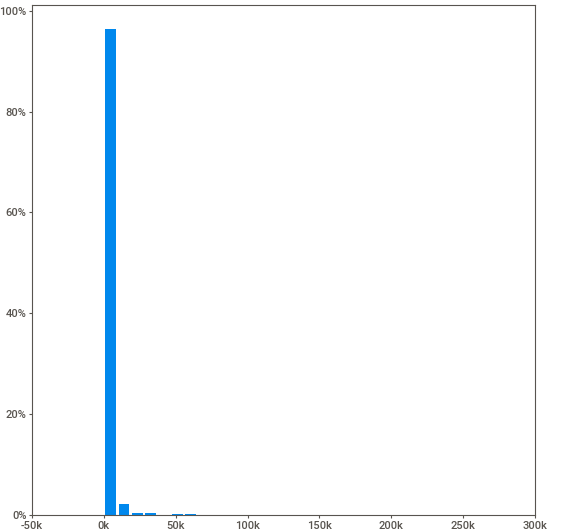
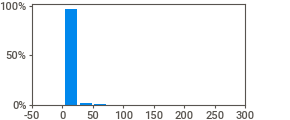
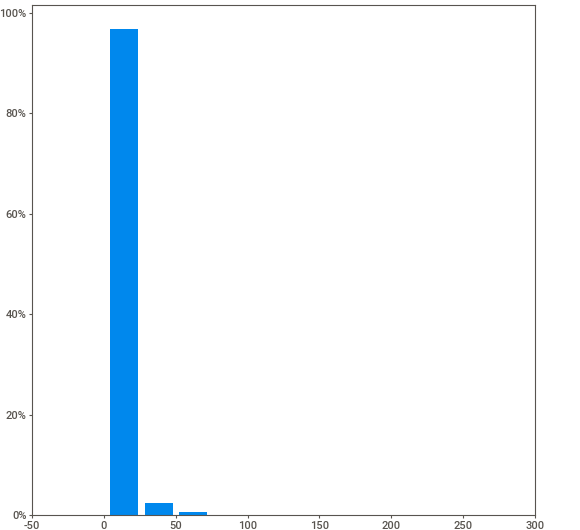
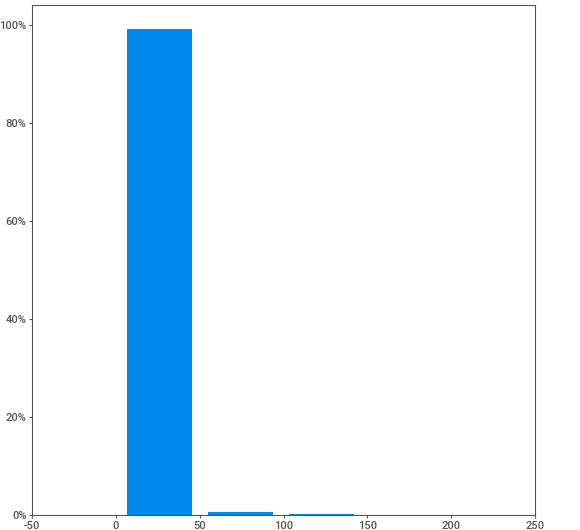
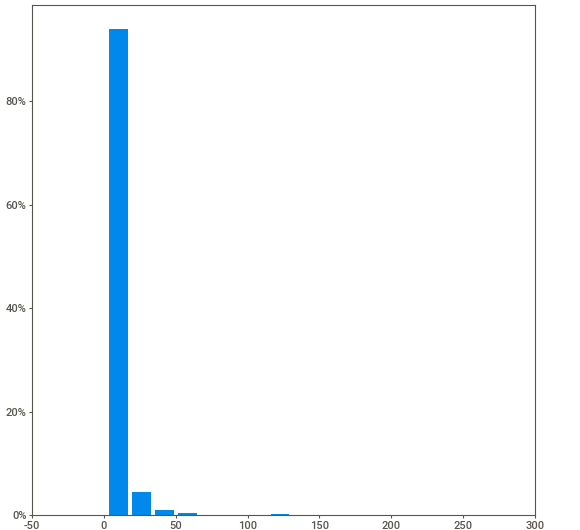
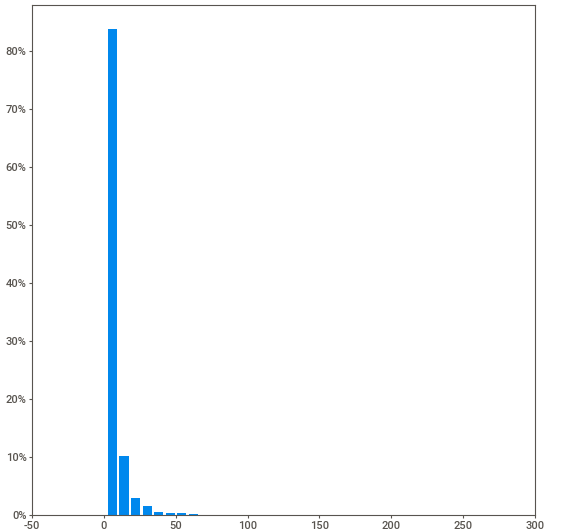
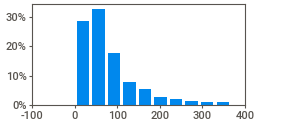
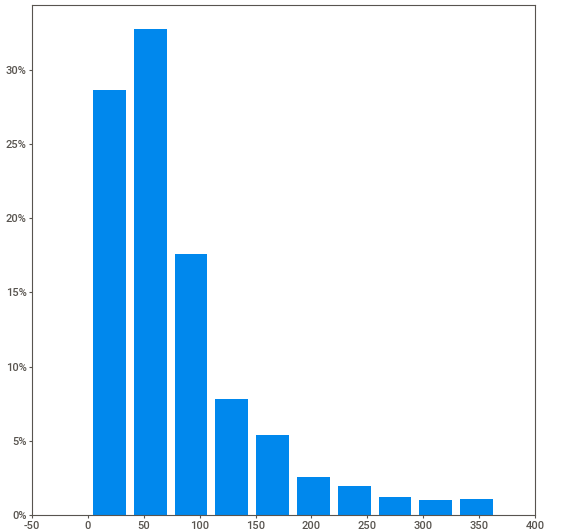
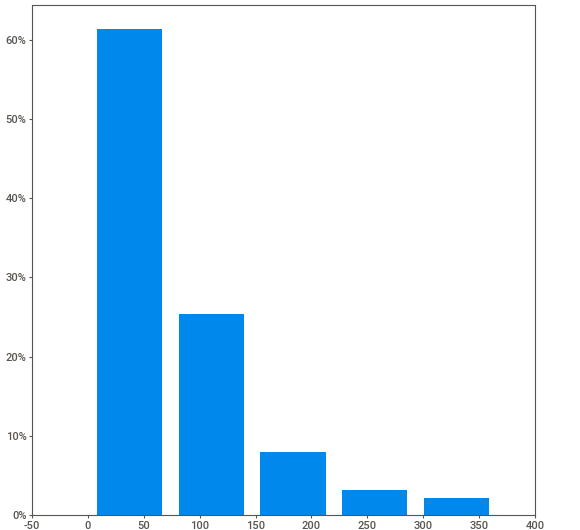
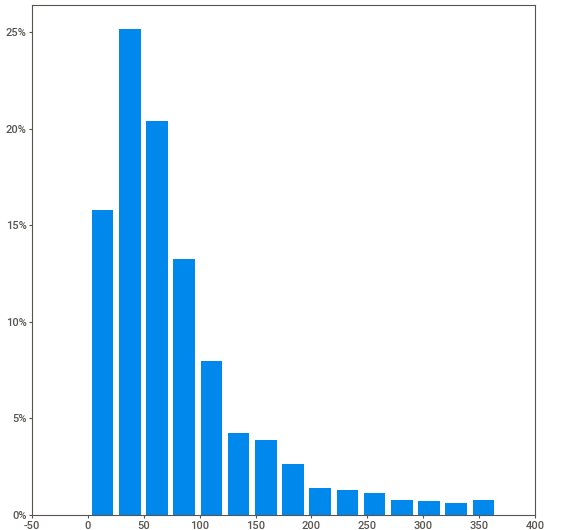
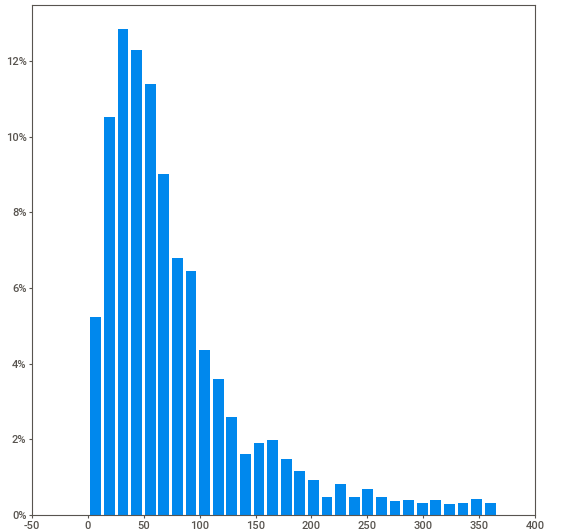
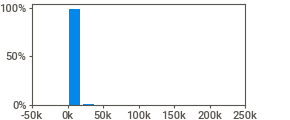
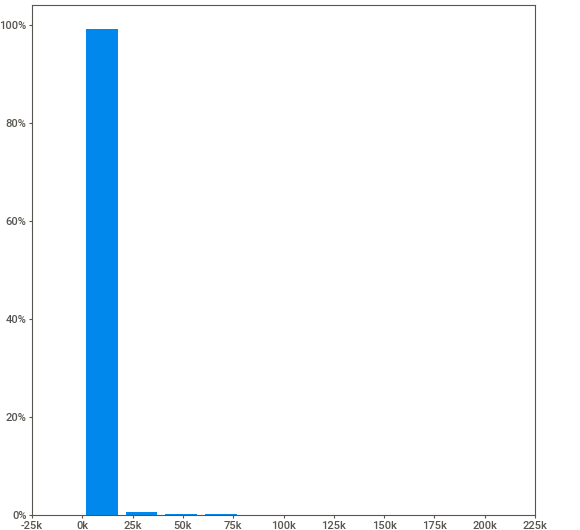
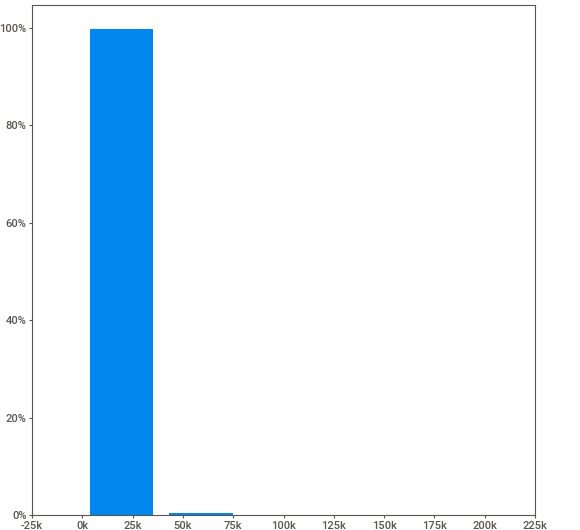
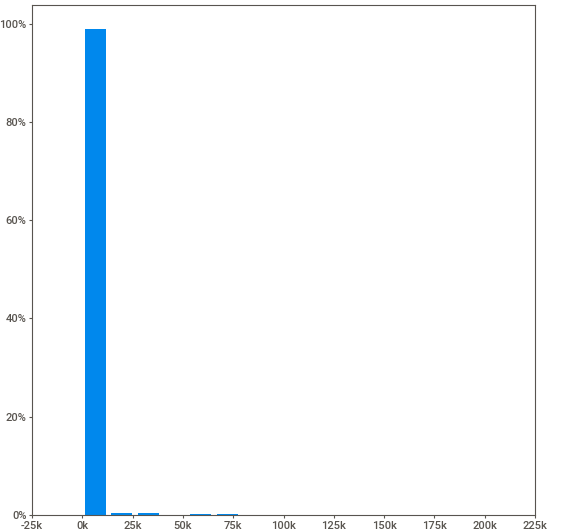
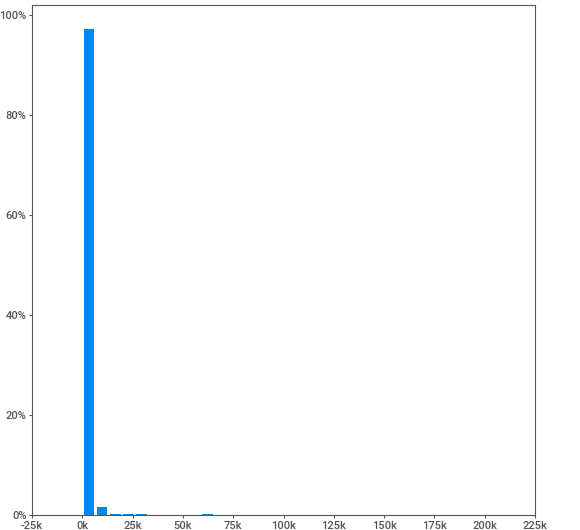
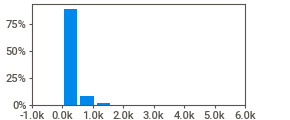
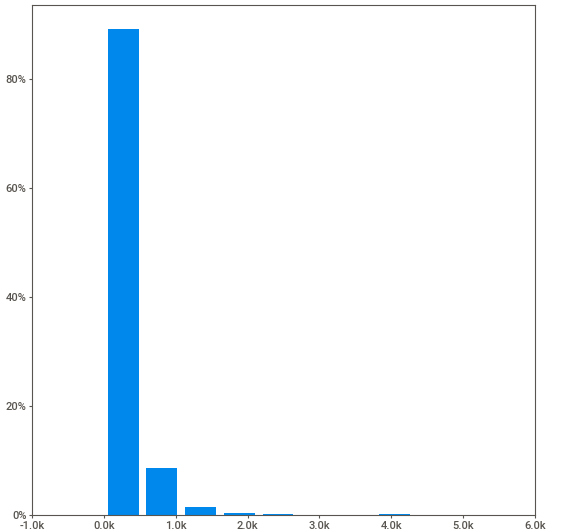
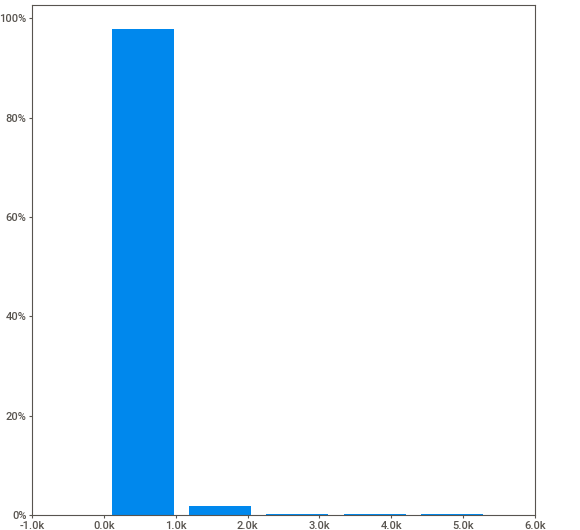
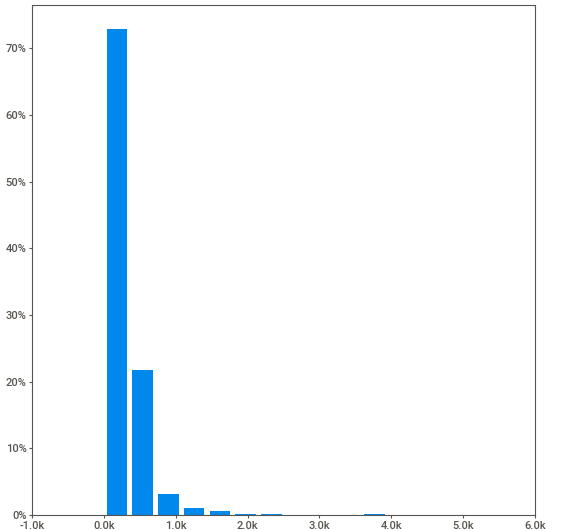
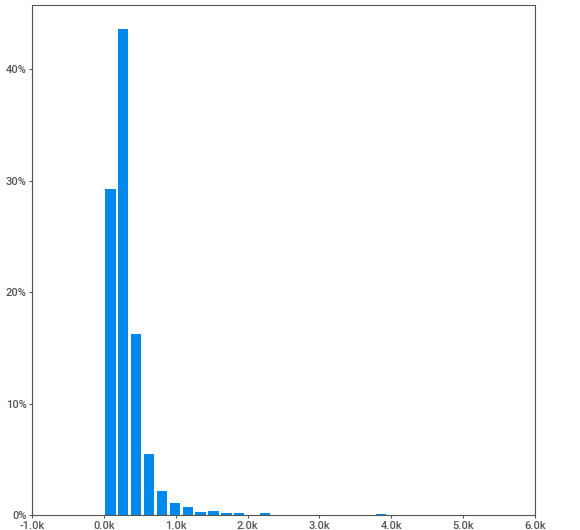
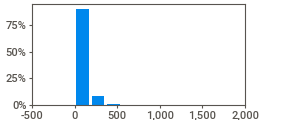
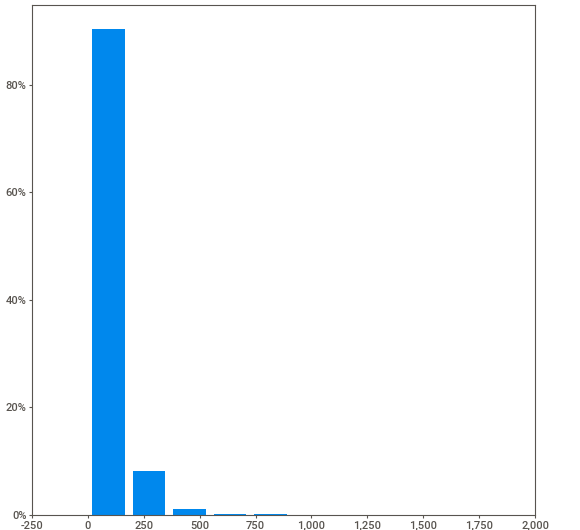
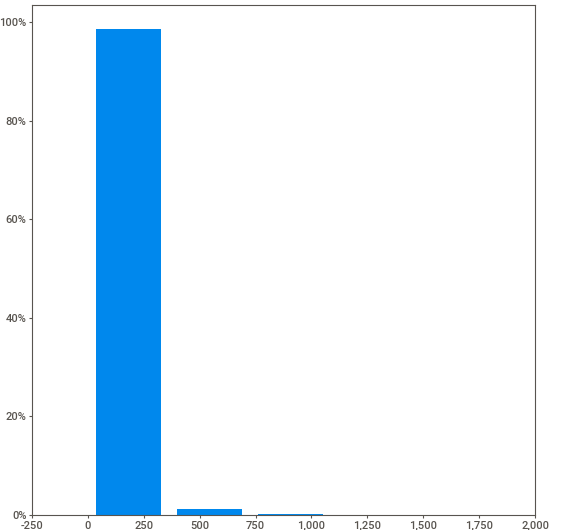
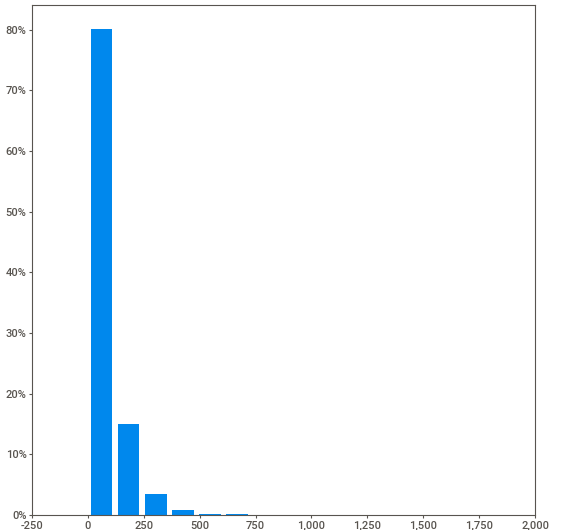
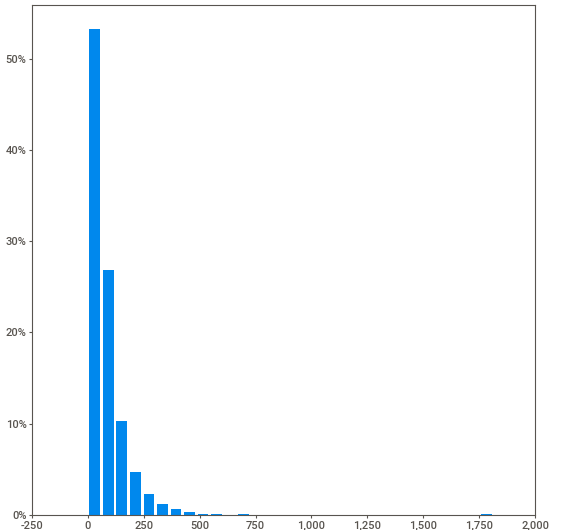
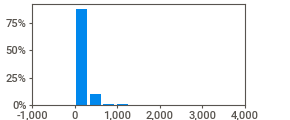
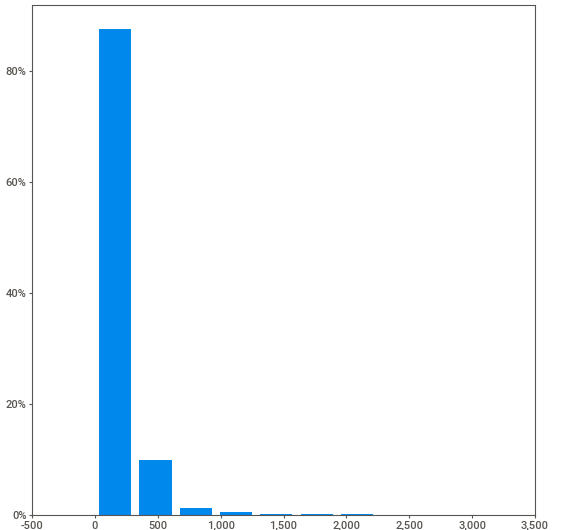
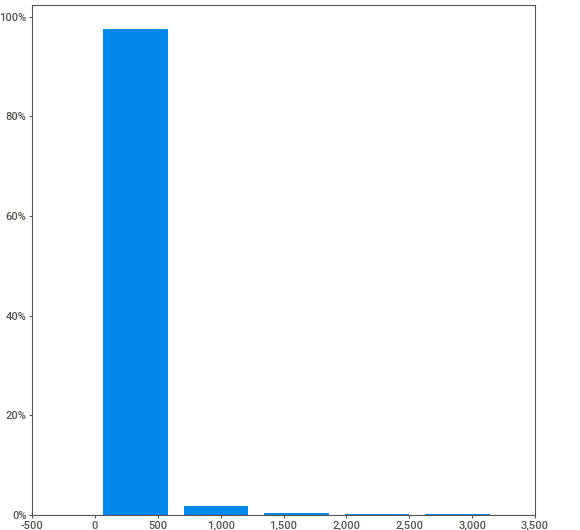
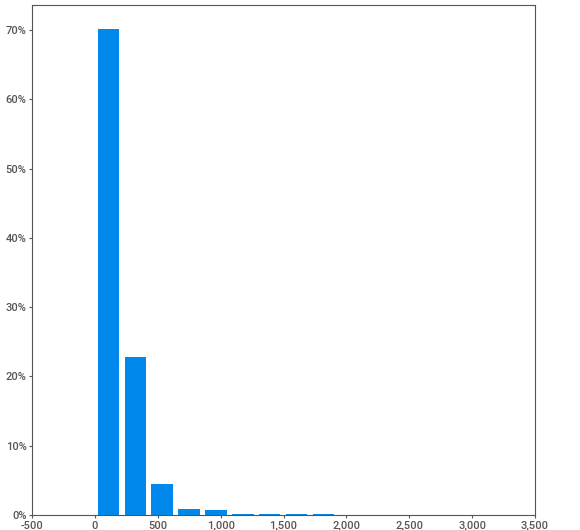
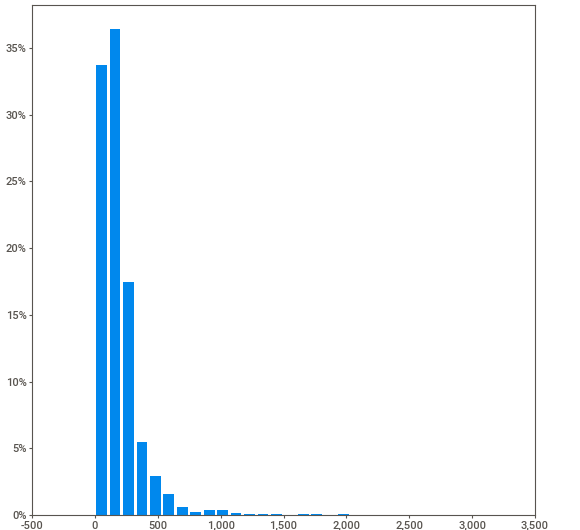
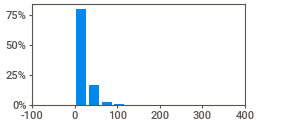
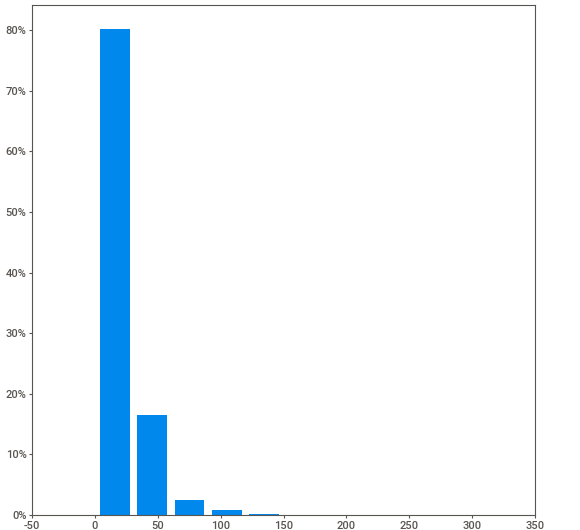
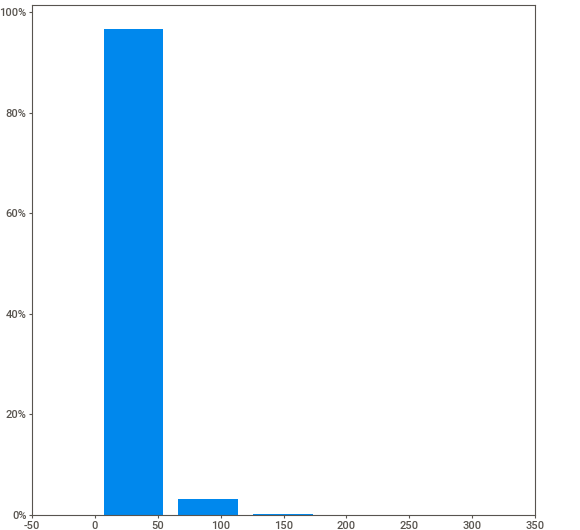
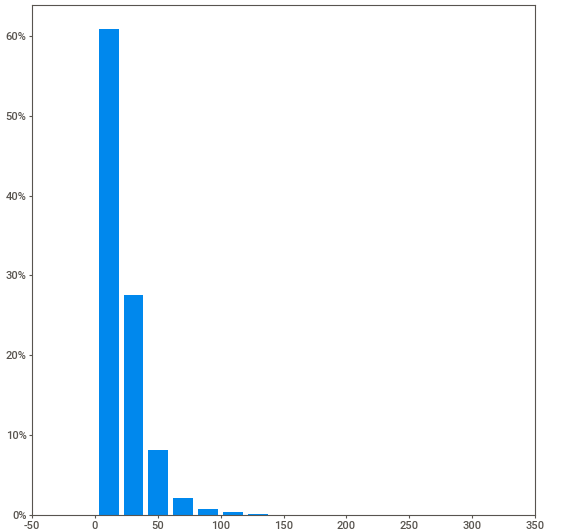
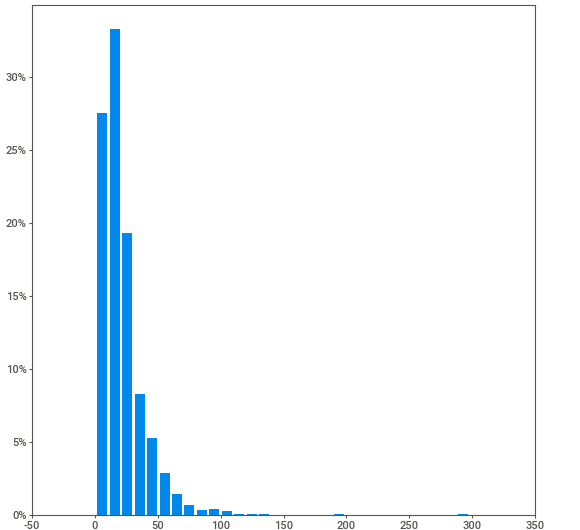
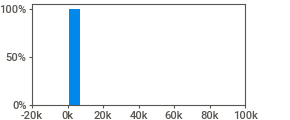
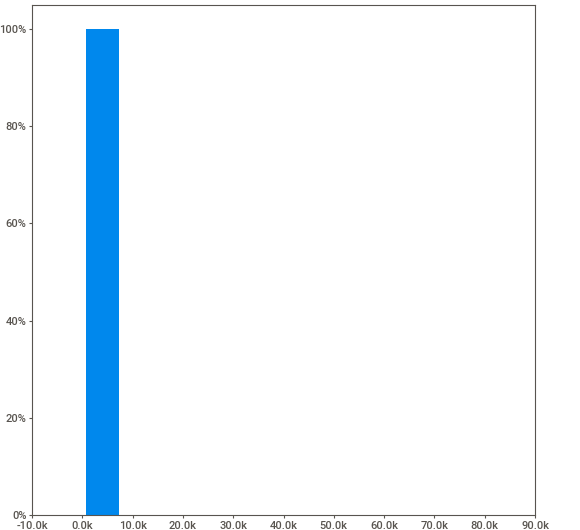
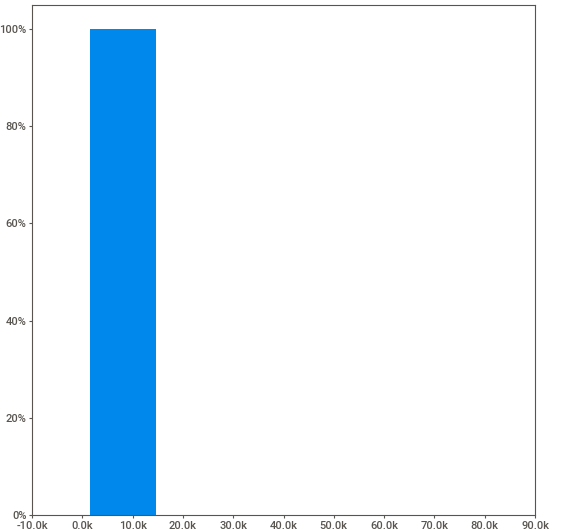
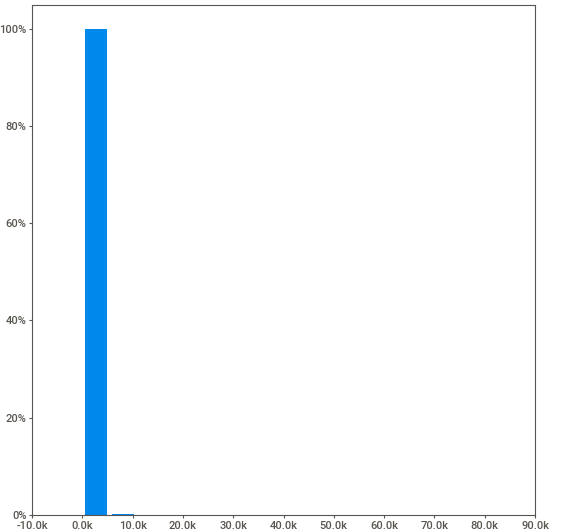
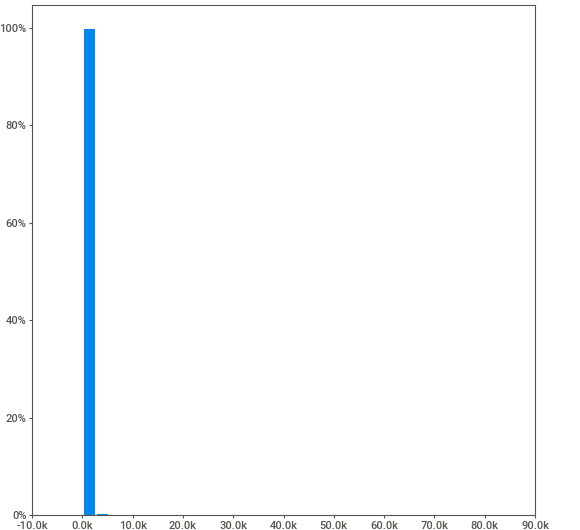
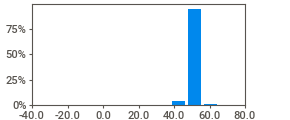
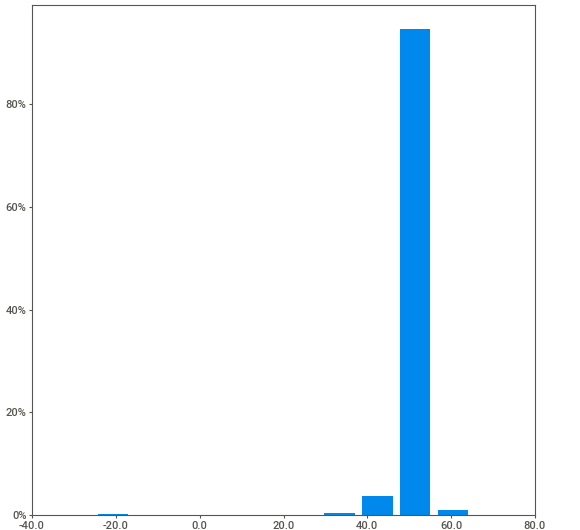
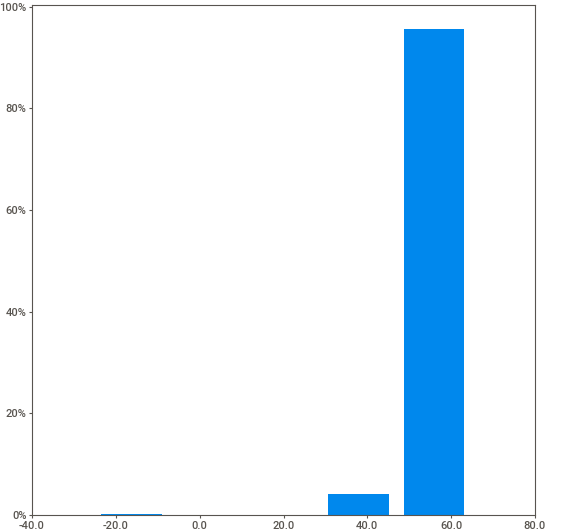
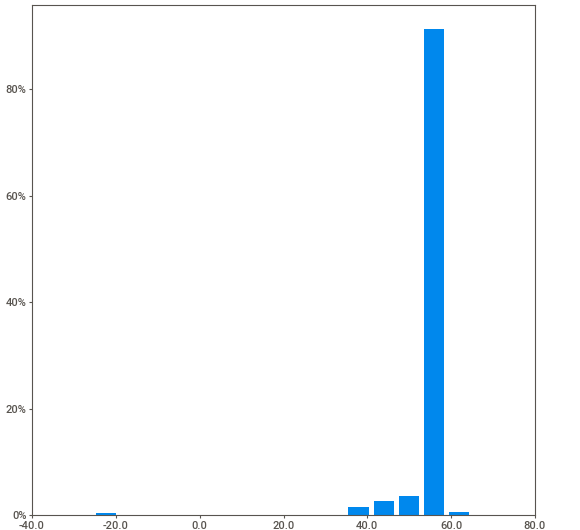
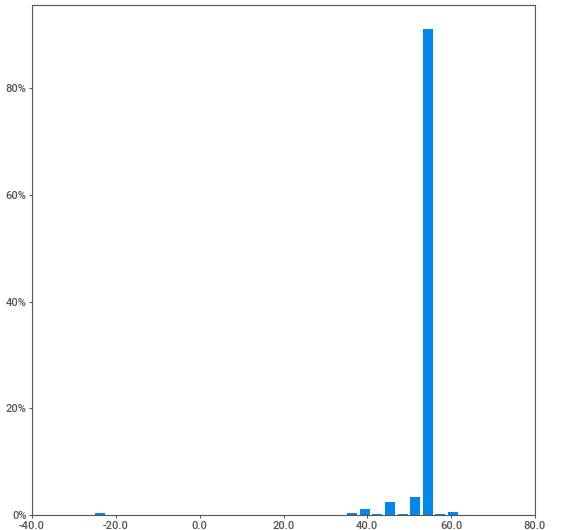
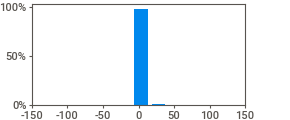
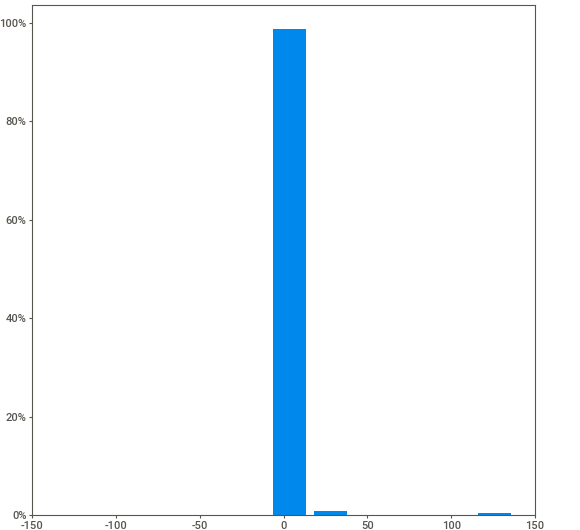
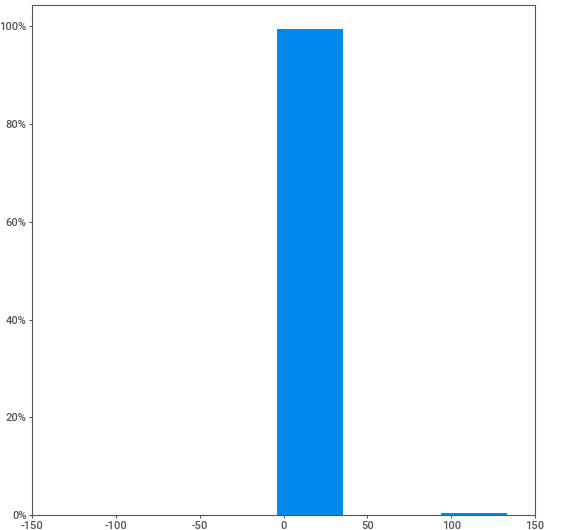
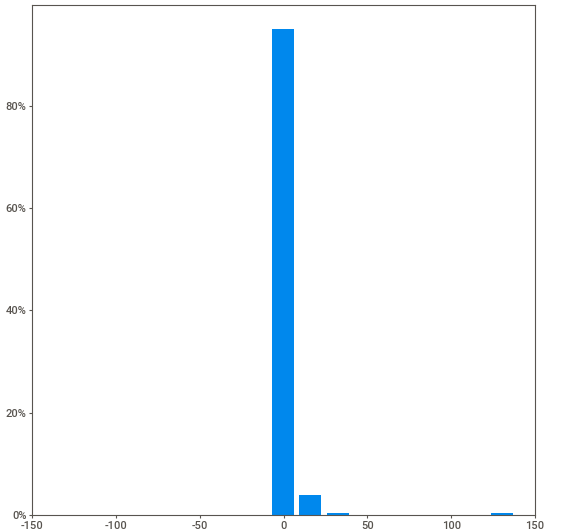
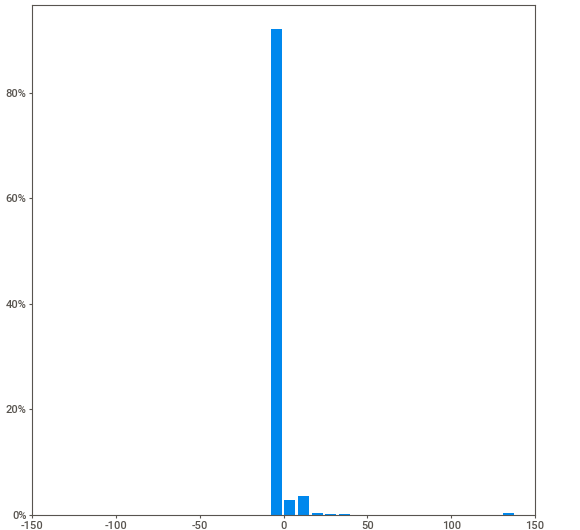
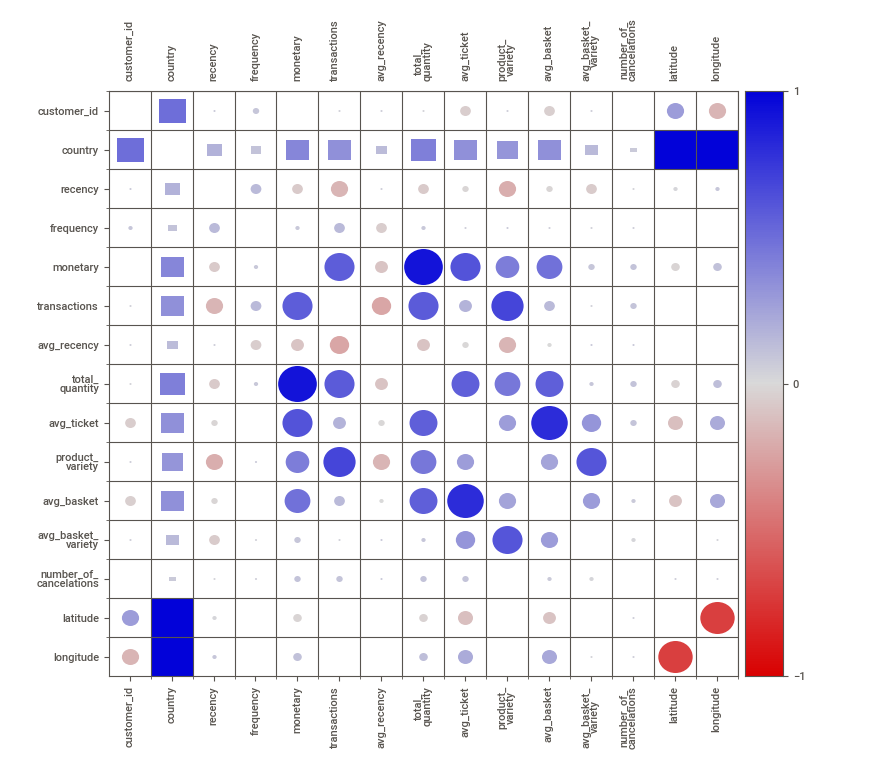
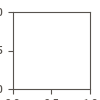

In [58]:
my_report = sweetviz.analyze(df_eda)
my_report.show_notebook(layout='widescreen')

### 4.1.1. Monetary

In [59]:
df_eda.sort_values('monetary', ascending=False).head(10)

customer_id         country  recency  frequency   monetary  transactions  \
772        14646     Netherlands      1.0   0.203390  278778.02            73   
384        18102  United Kingdom      0.0   0.163043  259657.30            60   
342        17450  United Kingdom      8.0   0.127778  189735.53            49   
54         14911         Ireland      1.0   0.533512  133007.13           243   
831        12415       Australia     24.0   0.063694  123638.18            24   
146        14156         Ireland      9.0   0.151515  114505.32            65   
14         17511  United Kingdom      2.0   0.083333   88138.20            45   
734        16684  United Kingdom      4.0   0.078873   65920.12            30   
30         13694  United Kingdom      3.0   0.134771   62924.10            57   
8          15311  United Kingdom      0.0   0.243316   59419.34           118   

     avg_recency  total_quantity   avg_ticket  product_variety   avg_basket  \
772     8.022727          196556  3818.876986            717.0  2692.547945   
384    14.680000           64124  4327.621667            162.0  1068.733333   
342    13.807692           69041  3872.153673            125.0  1409.000000   
54      2.861538           76931   547.354444           1815.0   316.588477   
831    22.357143           76946  5151.590833            450.0  3206.083333   
146     8.619048           57026  1761.620308            730.0   877.323077   
14     13.740741           63014  1958.626667            465.0  1400.311111   
734    23.600000           49391  2197.337333            121.0  1646.366667   
30     10.882353           61808  1103.931579            369.0  1084.350877   
8       4.191011           37720   503.553729            576.0   319.661017   

     avg_basket_variety  number_of_cancelations   latitude   longitude  
772           28.611111                   288.0  52.132633    5.291266  
384            7.183333                     0.0  55.378051   -3.435973  
342            7.304348                   952.0  55.378051   -3.435973  
54            28.482412                  3332.0  53.412910   -8.243890  
831           35.650000                   427.0 -25.274398  133.775136  
146           25.327273                   859.0  53.412910   -8.243890  
14            31.064516                  1535.0  55.378051   -3.435973  
734            9.892857                   864.0  55.378051   -3.435973  
30            11.360000                  1504.0  55.378051   -3.435973  
8             25.901099                   474.0  55.378051   -3.435973

These customers with very high monetary values don't seem to be outliers (errors), just excellent customers.

### 4.1.2. Product Variety

In [60]:
df_eda.sort_values('product_variety', ascending=False).head()

customer_id         country  recency  frequency   monetary  \
54          14911         Ireland      1.0   0.533512  133007.13   
39          12748  United Kingdom      0.0   0.550802   30486.53   
56          17841  United Kingdom      1.0   0.332440   40333.22   
2445        14096  United Kingdom      4.0   0.173469   53258.43   
637         14298  United Kingdom      8.0   0.124646   50862.44   

      transactions  avg_recency  total_quantity   avg_ticket  product_variety  \
54             243     2.861538           76931   547.354444           1815.0   
39             217     3.330357           23976   140.490922           1776.0   
56             169     3.351351           22850   238.658107           1344.0   
2445            17     6.062500           16336  3132.848824           1128.0   
637             45    14.666667           58021  1130.276444            891.0   

       avg_basket  avg_basket_variety  number_of_cancelations   latitude  \
54     316.588477           28.482412                  3332.0  53.412910   
39     110.488479           20.733010                  1535.0  55.378051   
56     135.207101           60.233871                   203.0  55.378051   
2445   960.941176          297.882353                     0.0  55.378051   
637   1289.355556           37.204545                   322.0  55.378051   

      longitude  
54    -8.243890  
39    -3.435973  
56    -3.435973  
2445  -3.435973  
637   -3.435973

### 4.1.3. Average Basket

In [61]:
df_eda.sort_values('avg_basket').head(5)

customer_id         country  recency  frequency  monetary  transactions  \
2034        16446  United Kingdom      0.0   0.009709      2.90             3   
1558        13452  United Kingdom    259.0   0.166667    590.00             2   
1427        16462  United Kingdom     73.0   0.014218    102.00             4   
588         18037  United Kingdom    154.0   0.028708     70.02             6   
973         17988  United Kingdom     11.0   0.022152    191.17             8   

      avg_recency  total_quantity  avg_ticket  product_variety  avg_basket  \
2034       205.00               2    0.966667              3.0    0.666667   
1558        11.00               2  295.000000              1.0    1.000000   
1427       105.00              12   25.500000              1.0    3.000000   
588         41.60              20   11.670000             19.0    3.333333   
973         78.75              42   23.896250             37.0    5.250000   

      avg_basket_variety  number_of_cancelations   latitude  longitude  
2034            1.500000                 80995.0  55.378051  -3.435973  
1558            1.000000                     0.0  55.378051  -3.435973  
1427            1.000000                     4.0  55.378051  -3.435973  
588             3.166667                     0.0  55.378051  -3.435973  
973             5.428571                     1.0  55.378051  -3.435973

In [62]:
df_eda.sort_values('avg_basket', ascending=False).head(5)

customer_id         country  recency  frequency   monetary  \
831         12415       Australia     24.0   0.063694  123638.18   
779         13027  United Kingdom    113.0   0.024793    6912.00   
772         14646     Netherlands      1.0   0.203390  278778.02   
910         15749  United Kingdom    235.0   0.030612   21535.90   
1199        12754           Japan    235.0   0.040541    3010.74   

      transactions  avg_recency  total_quantity   avg_ticket  product_variety  \
831             24    22.357143           76946  5151.590833            450.0   
779              6    48.200000           17280  1152.000000              6.0   
772             73     8.022727          196556  3818.876986            717.0   
910              4    97.000000            9014  5383.975000              5.0   
1199             3    36.500000            6481  1003.580000             49.0   

       avg_basket  avg_basket_variety  number_of_cancelations   latitude  \
831   3206.083333           35.650000                   427.0 -25.274398   
779   2880.000000            4.333333                     0.0  55.378051   
772   2692.547945           28.611111                   288.0  52.132633   
910   2253.500000            3.333333                  9014.0  55.378051   
1199  2160.333333           21.000000                     0.0  36.204824   

       longitude  
831   133.775136  
779    -3.435973  
772     5.291266  
910    -3.435973  
1199  138.252924

### 4.1.4. Number of Cancellations

In [63]:
df_eda.sort_values('number_of_cancelations', ascending=False).head(5)

customer_id         country  recency  frequency  monetary  transactions  \
2034        16446  United Kingdom      0.0   0.009709      2.90             3   
121         15838  United Kingdom     11.0   0.053221  33362.28            20   
910         15749  United Kingdom    235.0   0.030612  21535.90             4   
11          16029  United Kingdom     38.0   0.184524  58193.85            66   
747         12931  United Kingdom     21.0   0.044510  33544.81            19   

      avg_recency  total_quantity   avg_ticket  product_variety   avg_basket  \
2034   205.000000               2     0.966667              3.0     0.666667   
121     25.428571            9008  1668.114000             54.0   450.400000   
910     97.000000            9014  5383.975000              5.0  2253.500000   
11       9.054054           32203   881.725000             44.0   487.924242   
747     30.545455           23577  1765.516316             30.0  1240.894737   

      avg_basket_variety  number_of_cancelations   latitude  longitude  
2034            1.500000                 80995.0  55.378051  -3.435973  
121             8.789474                  9360.0  55.378051  -3.435973  
910             3.333333                  9014.0  55.378051  -3.435973  
11              3.854839                  8004.0  55.378051  -3.435973  
747             5.266667                  4427.0  55.378051  -3.435973

In [64]:
df_eda.query('number_of_cancelations > 1000 & (transactions < 10 or total_quantity < 1000)')

customer_id         country  recency  frequency  monetary  transactions  \
795         14533  United Kingdom     24.0   0.021277   1812.62             9   
910         15749  United Kingdom    235.0   0.030612  21535.90             4   
1198        16938  United Kingdom      8.0   0.013289   1903.13             5   
2034        16446  United Kingdom      0.0   0.009709      2.90             3   

      avg_recency  total_quantity   avg_ticket  product_variety   avg_basket  \
795     54.666667            2777   201.402222             53.0   308.555556   
910     97.000000            9014  5383.975000              5.0  2253.500000   
1198   100.000000            1025   380.626000            215.0   205.000000   
2034   205.000000               2     0.966667              3.0     0.666667   

      avg_basket_variety  number_of_cancelations   latitude  longitude  
795             8.857143                  1242.0  55.378051  -3.435973  
910             3.333333                  9014.0  55.378051  -3.435973  
1198           57.750000                  1515.0  55.378051  -3.435973  
2034            1.500000                 80995.0  55.378051  -3.435973

I will remove customer 16446 since this is the only one with very few quantities and transactions with an extreme value for the number of cancellations, which indicates that some error occurred.

### 4.1.7 Quantity

In [65]:
df_eda.sort_values('total_quantity', ascending=False).head()

customer_id         country  recency  frequency   monetary  transactions  \
772        14646     Netherlands      1.0   0.203390  278778.02            73   
831        12415       Australia     24.0   0.063694  123638.18            24   
54         14911         Ireland      1.0   0.533512  133007.13           243   
342        17450  United Kingdom      8.0   0.127778  189735.53            49   
384        18102  United Kingdom      0.0   0.163043  259657.30            60   

     avg_recency  total_quantity   avg_ticket  product_variety   avg_basket  \
772     8.022727          196556  3818.876986            717.0  2692.547945   
831    22.357143           76946  5151.590833            450.0  3206.083333   
54      2.861538           76931   547.354444           1815.0   316.588477   
342    13.807692           69041  3872.153673            125.0  1409.000000   
384    14.680000           64124  4327.621667            162.0  1068.733333   

     avg_basket_variety  number_of_cancelations   latitude   longitude  
772           28.611111                   288.0  52.132633    5.291266  
831           35.650000                   427.0 -25.274398  133.775136  
54            28.482412                  3332.0  53.412910   -8.243890  
342            7.304348                   952.0  55.378051   -3.435973  
384            7.183333                     0.0  55.378051   -3.435973

Notes


**Recency:** Average Variability (good distribution for clustering)

**Frequency:** Low Variability (Highly concentrated distibution)

**Monetary:** High Variability (Highly concentrated in low values)

**Transactions:** Average Variability (Highly concentrated in low values)

**Average Ticket:** High Variability (Highly concentrated in low values)

**Product Variety:** High Variability (Highly concentrated but more sparse than the other features)

**Average Basket Size:** High Variability (Highly concentrated in low values)

**Average Basket Variety:** Average Variability (High concentration in low values, but more evenly distributed)

**Number of Cancellations:** High Variability (Highly concentrated in low values with a huge outlier)

**Removing bad users**

In [66]:

df_eda = df_eda.query('~(customer_id == 16446)').copy()

## 4.3 Bivariate Analysis

In [67]:
#sns.pairplot(df_eda.drop(columns=['customer_id', 'country', 'frequency']))
#plt.figure(figsize=(12, 20))
fig = px.scatter_matrix(df_eda.drop(['country', 'customer_id', 'latitude', 'longitude'], axis=1), )
fig.update_layout(width=2000, height=1000, font={'size': 9})
fig.show()

**Notes**

Frequency has low variance
Avg ticket


## 4.4. Embedding 

In [68]:
df_embed = df_eda.drop(columns=['customer_id', 'country', 'latitude', 'longitude']).copy()

In [69]:
df_embed.head()

recency  frequency  monetary  transactions  avg_recency  total_quantity  \
0    372.0  17.000000   5288.63            35     1.000000            1693   
1     56.0   0.028302   3089.10            16    52.833333            1355   
2      2.0   0.040323   6629.34            17    26.500000            4978   
3     95.0   0.017921    948.25             5    92.666667             439   
4    333.0   0.073171    635.10             6    20.000000              58   

   avg_ticket  product_variety  avg_basket  avg_basket_variety  \
0  151.103714             21.0   48.371429            8.735294   
1  193.068750            105.0   84.687500           19.000000   
2  389.961176            116.0  292.823529           15.466667   
3  189.650000             24.0   87.800000            5.600000   
4  105.850000              1.0    9.666667            1.000000   

   number_of_cancelations  
0                    40.0  
1                    35.0  
2                    50.0  
3                     0.0  
4                    22.0

## 4.4.1 PCA

In [70]:
scaler = pp.MinMaxScaler()
df_embed_sc = scaler.fit_transform(df_embed)

pca = PCA(n_components=df_embed_sc.shape[1])
pca.fit(df_embed_sc)
df_pca = pca.transform(df_embed_sc)
print(f'Original shape: {str(df_embed_sc.shape)}')
print(f'Reduced shape: {str(df_pca.shape)}')
print(f'{sum(pca.explained_variance_ratio_):.3f}')

Original shape: (2771, 11)
Reduced shape: (2771, 11)
1.000


<AxesSubplot: >

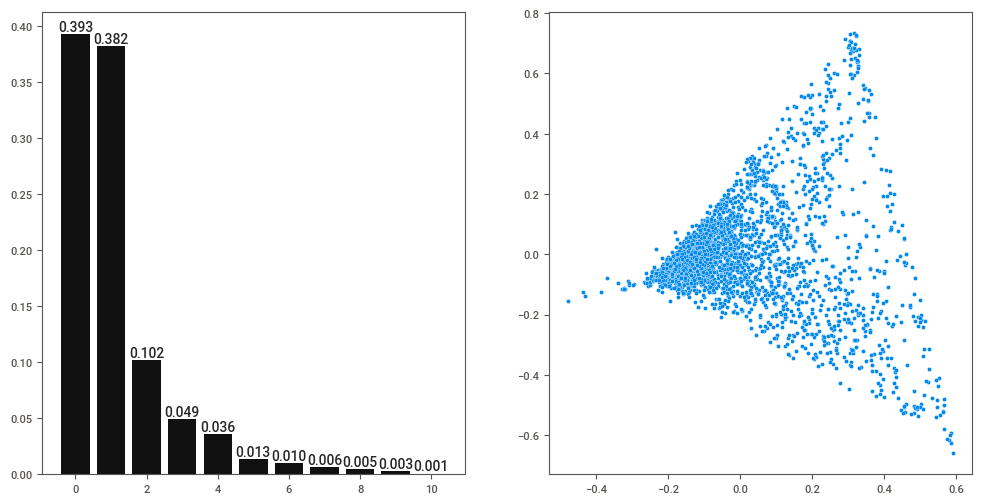

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x_pos = np.arange(pca.n_components_)
bar = ax[0].bar(x=x_pos, height=pca.explained_variance_ratio_, color='k')

ax[0].bar_label(bar, fmt='%.3f');

sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], ax=ax[1])

## 4.4.2 T-SNE

<AxesSubplot: >

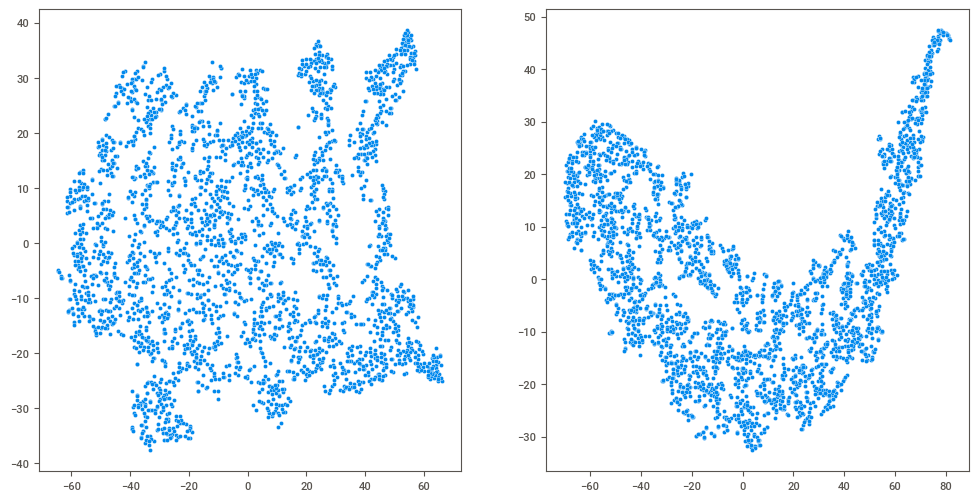

In [72]:
tsne = man.TSNE(perplexity=40, n_iter=1500, random_state=42, n_components=2)

df_tsne_sc = tsne.fit_transform(df_embed_sc)
df_tsne = tsne.fit_transform(df_embed)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_tsne_sc[:, 0], y=df_tsne_sc[:, 1])

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1])

## 4.4.3 UMAP

<AxesSubplot: >

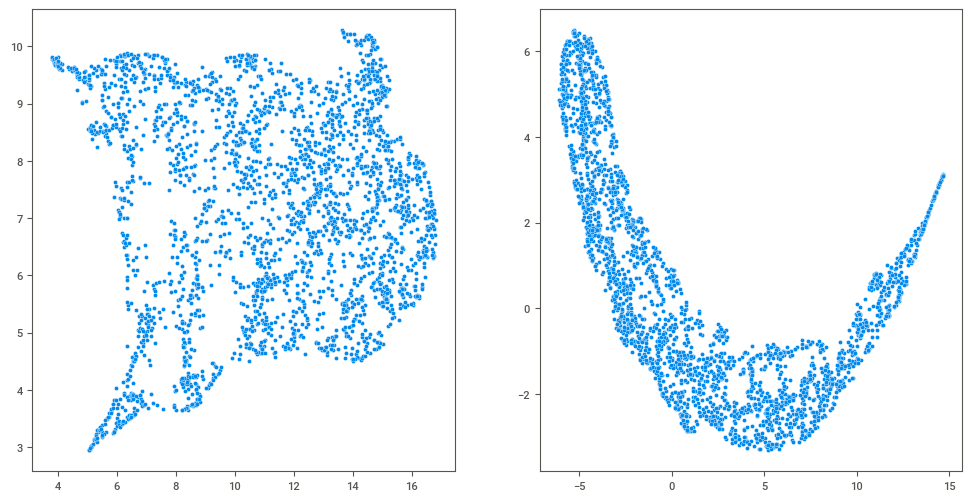

In [73]:
umap = um.UMAP(n_neighbors=40, random_state=42)

df_umap_sc = umap.fit_transform(df_embed_sc)
df_umap = umap.fit_transform(df_embed)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_umap_sc[:, 0], y=df_umap_sc[:, 1])

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1])


## 4.4.4. Tree-Based Embedding

Vraiable that organize the customers in a way that I can group the most valuable clients.

In [74]:
X = df_embed.drop(columns='monetary')
y = df_embed['monetary']


# model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# training
rf.fit(X, y)

# Aplying the tree structure in the training set (Leafs)
df_leaf = pd.DataFrame(rf.apply(X)) 
#X.head()

Dados separados por folhas (pontos em cada estimadores).
Em qual folha o cliente caiu em cada árvore

In [75]:
df_leaf.shape

(2771, 100)

<AxesSubplot: >

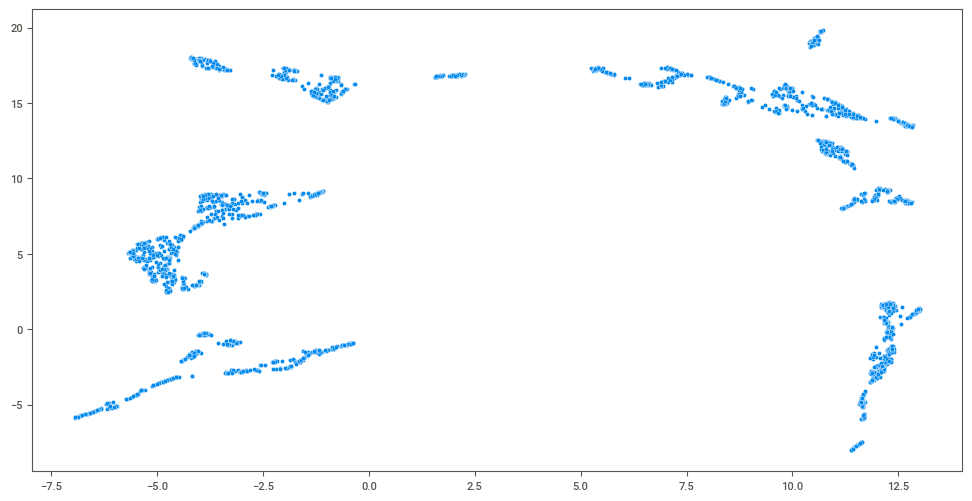

In [76]:
umap = um.UMAP(n_neighbors=40, random_state=42)

df_umap = umap.fit_transform(df_leaf)

plt.figure(figsize=(12, 6))

sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1])


Não preciso explicar porque dois elementos são vizinhos

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 5.0. Data Preparation

In [77]:
df_prep = df_eda.copy()

In [78]:
std = Pipeline([('standard', pp.StandardScaler())])
minmax = Pipeline([('minmax', pp.MinMaxScaler())])
robust = Pipeline([('robust', pp.RobustScaler())])
cols = ['recency', 'frequency', 'monetary', 'total_quantity', 'transactions', 'avg_recency', 'avg_ticket', 'product_variety', 'avg_basket', 'number_of_cancelations', 'latitude', 'longitude']
pass_cols = ['customer_id'] 

preprocess = ColumnTransformer([('pass', 'passthrough', pass_cols), ('minmax', minmax, cols)])
#std_preprocess = ColumnTransformer([('pass', 'passthrough', pass_cols), ('standard', std, cols)])

#### Rule of thumb

Rescale x Standardization
1. Normal distribution without outliers -> Standard Scaler
2. Normal distribution with Outliers -> Robust Scaler
3. Not normal distribution -> Min Max Scaler

**Normality Tests**

QQ Plot -> Quantile Plot 

KS Test -> Kolmogorov Smirnoff (Hypothesis Test)


**Outlier detection**

Box Plot (2.5 IQ)

Z-Score > 3
Z-Score < -3


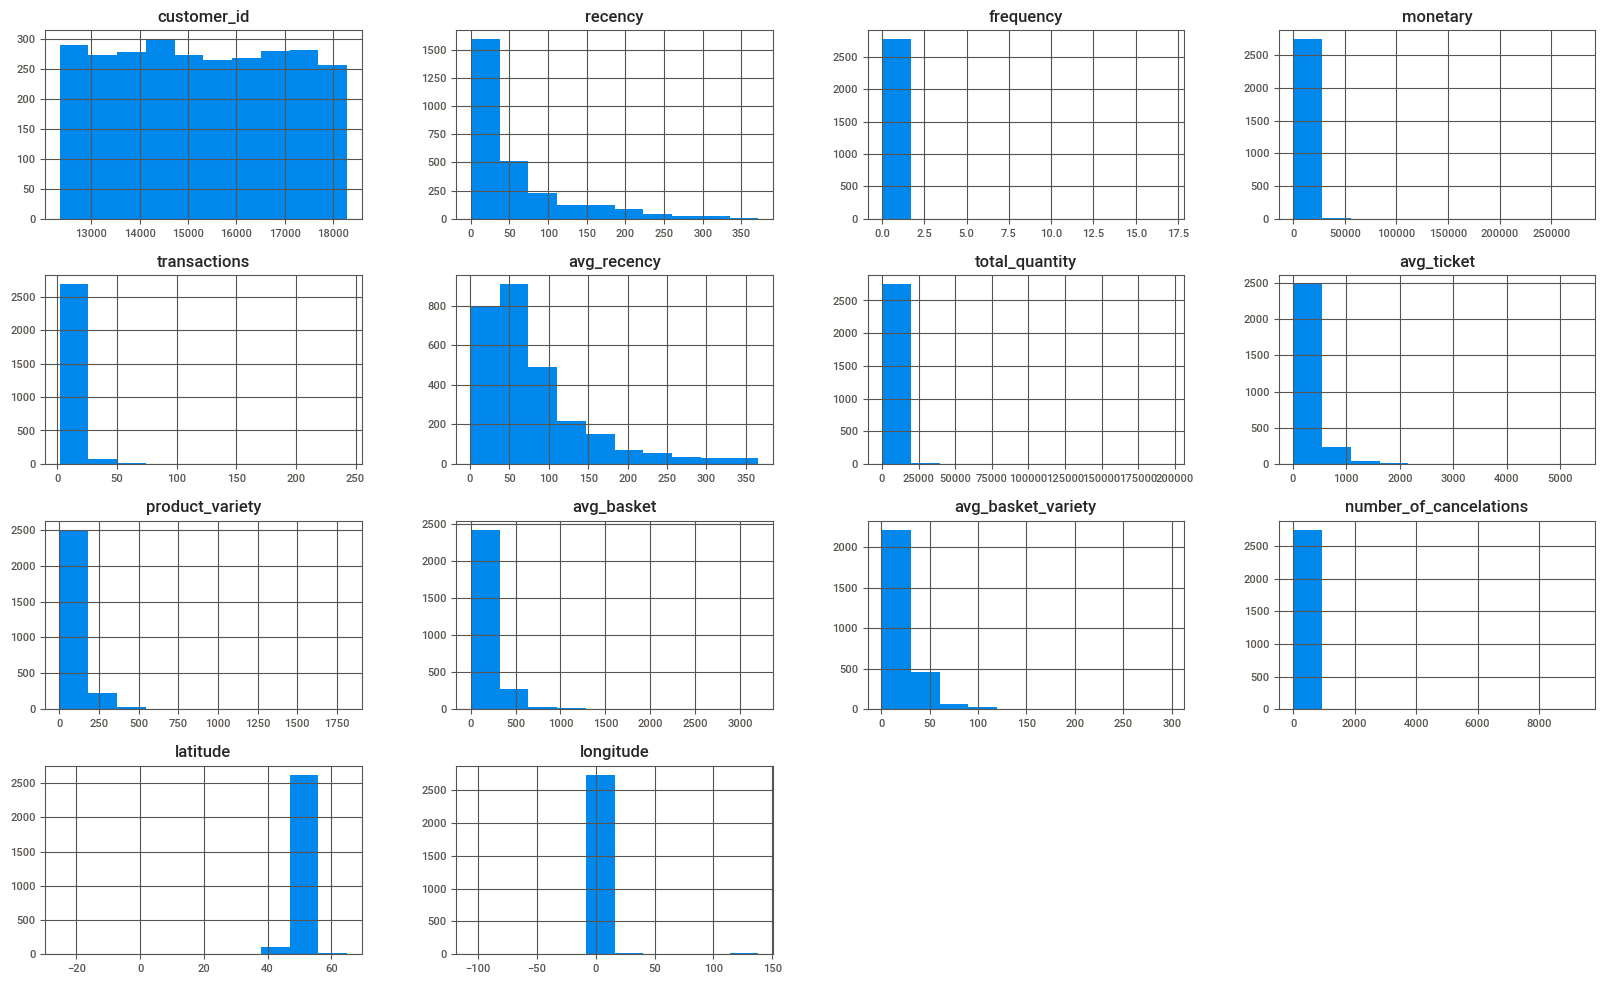

In [79]:
df_prep.hist(figsize=(20, 12));

Now will test for normality using the Kolmorogov Test.

In [80]:
tests = {}
for col in df_prep.columns.to_list():
    stat, p = kstest(df_prep.recency, cdf='norm')
    if p < 0.05:
        result = 'Not Normal'
    else:
        result = 'Normal'
    tests[col] = p, result
pd.DataFrame(tests).T.rename(columns={0: 'p-value', 1: 'Result'})

p-value      Result
customer_id                0.0  Not Normal
country                    0.0  Not Normal
recency                    0.0  Not Normal
frequency                  0.0  Not Normal
monetary                   0.0  Not Normal
transactions               0.0  Not Normal
avg_recency                0.0  Not Normal
total_quantity             0.0  Not Normal
avg_ticket                 0.0  Not Normal
product_variety            0.0  Not Normal
avg_basket                 0.0  Not Normal
avg_basket_variety         0.0  Not Normal
number_of_cancelations     0.0  Not Normal
latitude                   0.0  Not Normal
longitude                  0.0  Not Normal

## Q-Q Plot

In [81]:
def qq_plot(feature):

    n = df_prep[feature].shape[0]

    standard_feat = std.fit_transform(df_prep[feature].values.reshape(-1, 1))
    
    quants = [np.quantile(standard_feat, q=i/n) for i in range(1, n+1)]

    norm = np.random.normal(size=n)
    norm_quants = [np.quantile(norm, q=i/n) for i in range(1, n+1)]
    sns.lineplot(x=norm_quants, y=norm_quants)
    sns.scatterplot(x=norm_quants, y=quants)

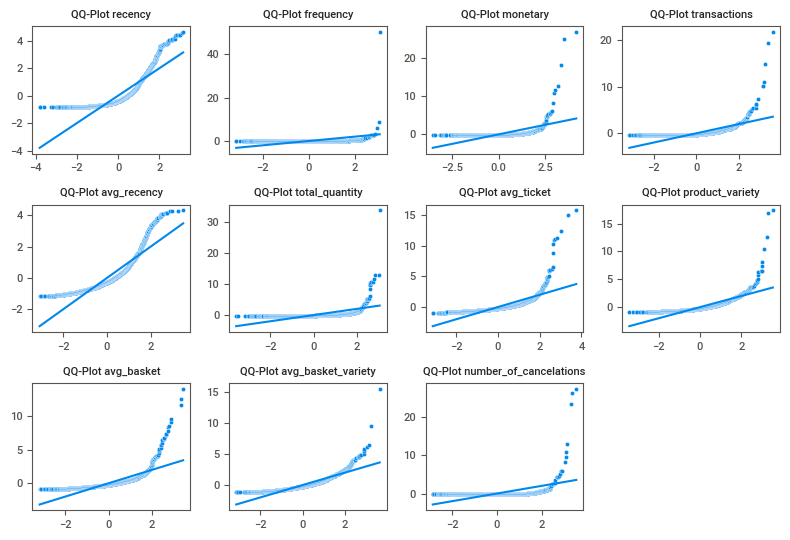

In [82]:
k = 1
columns = df_prep.drop(columns=['customer_id', 'latitude', 'longitude', 'country']).columns
n_plots = len(columns)
ncols = 4
nrows = int(np.ceil(n_plots/ncols))
for feature in columns:

    plt.subplot(nrows, ncols, k)
    plt.title(f'QQ-Plot {feature}', fontsize=8)
    qq_plot(feature)
    plt.tight_layout()
    k += 1
    
    #print(k)

None of the features follows a normal distribution.

**Using Min Max Scaler for all features.**

In [83]:
#df_prep_scaled
df_prep_scaled = pd.DataFrame(preprocess.fit_transform(df_prep))
cols = ['customer_id', 'recency', 'frequency', 'monetary', 'total_quantity', 'transactions', 'avg_recency', 'avg_ticket', 'product_variety', 'avg_basket', 'number_of_cancelations', 'latitude', 'longitude']
df_prep_scaled.columns = cols

In [84]:
df_prep_scaled.head()

customer_id   recency  frequency  monetary  total_quantity  transactions  \
0      17850.0  1.000000   1.000000  0.018842        0.008603      0.136929   
1      13047.0  0.150538   0.001345  0.010951        0.006884      0.058091   
2      12583.0  0.005376   0.002052  0.023652        0.025316      0.062241   
3      13748.0  0.255376   0.000734  0.003271        0.002223      0.012448   
4      15100.0  0.895161   0.003985  0.002147        0.000285      0.016598   

   avg_recency  avg_ticket  product_variety  avg_basket  \
0     0.000000    0.026413         0.011025    0.014780   
1     0.142009    0.034220         0.057332    0.026111   
2     0.069863    0.070853         0.063396    0.091050   
3     0.251142    0.033584         0.012679    0.027082   
4     0.052055    0.017993         0.000000    0.002704   

   number_of_cancelations  latitude  longitude  
0                0.004274  0.893780   0.420732  
1                0.003739  0.893780   0.420732  
2                0.005342  0.792377   0.443829  
3                0.000000  0.893780   0.420732  
4                0.002350  0.893780   0.420732

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 6.0. Feature Selection

In [142]:
# avg_basket
# avg_recency
# items
# Transaction

columns_selected = ['customer_id', 'recency', 'frequency', 'monetary', 'transactions', 'product_variety', 'number_of_cancelations']

In [143]:
df_fselect = df_prep.copy()[columns_selected]
df_fselect_sc = df_prep_scaled.copy()[columns_selected]

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 7.0. Hyperparameter Fine-Tuning

In [144]:
X = df_fselect_sc.copy().reset_index(drop=True).drop(columns=['customer_id'])

In [145]:
X.head()

recency  frequency  monetary  transactions  product_variety  \
0  1.000000   1.000000  0.018842      0.136929         0.011025   
1  0.150538   0.001345  0.010951      0.058091         0.057332   
2  0.005376   0.002052  0.023652      0.062241         0.063396   
3  0.255376   0.000734  0.003271      0.012448         0.012679   
4  0.895161   0.003985  0.002147      0.016598         0.000000   

   number_of_cancelations  
0                0.004274  
1                0.003739  
2                0.005342  
3                0.000000  
4                0.002350

## 7.1 K-Means

In [146]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans_list = []
for k in clusters:
    
    kmeans_model = KMeans(n_clusters=k, )

    kmeans_model.fit(X)

    labels = kmeans_model.predict(X)

    # performance

    sil = mt.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'Elbow Plot')

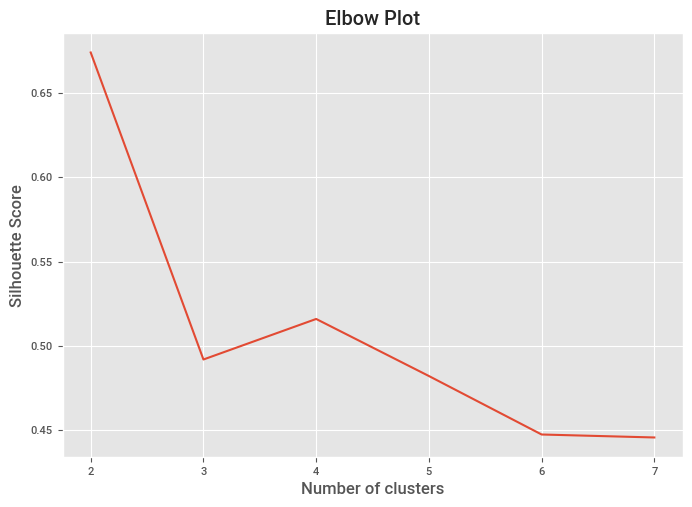

In [147]:
plt.plot(clusters, kmeans_list)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Elbow Plot')

### 7.1.1 Silhouette Analysis K-Means

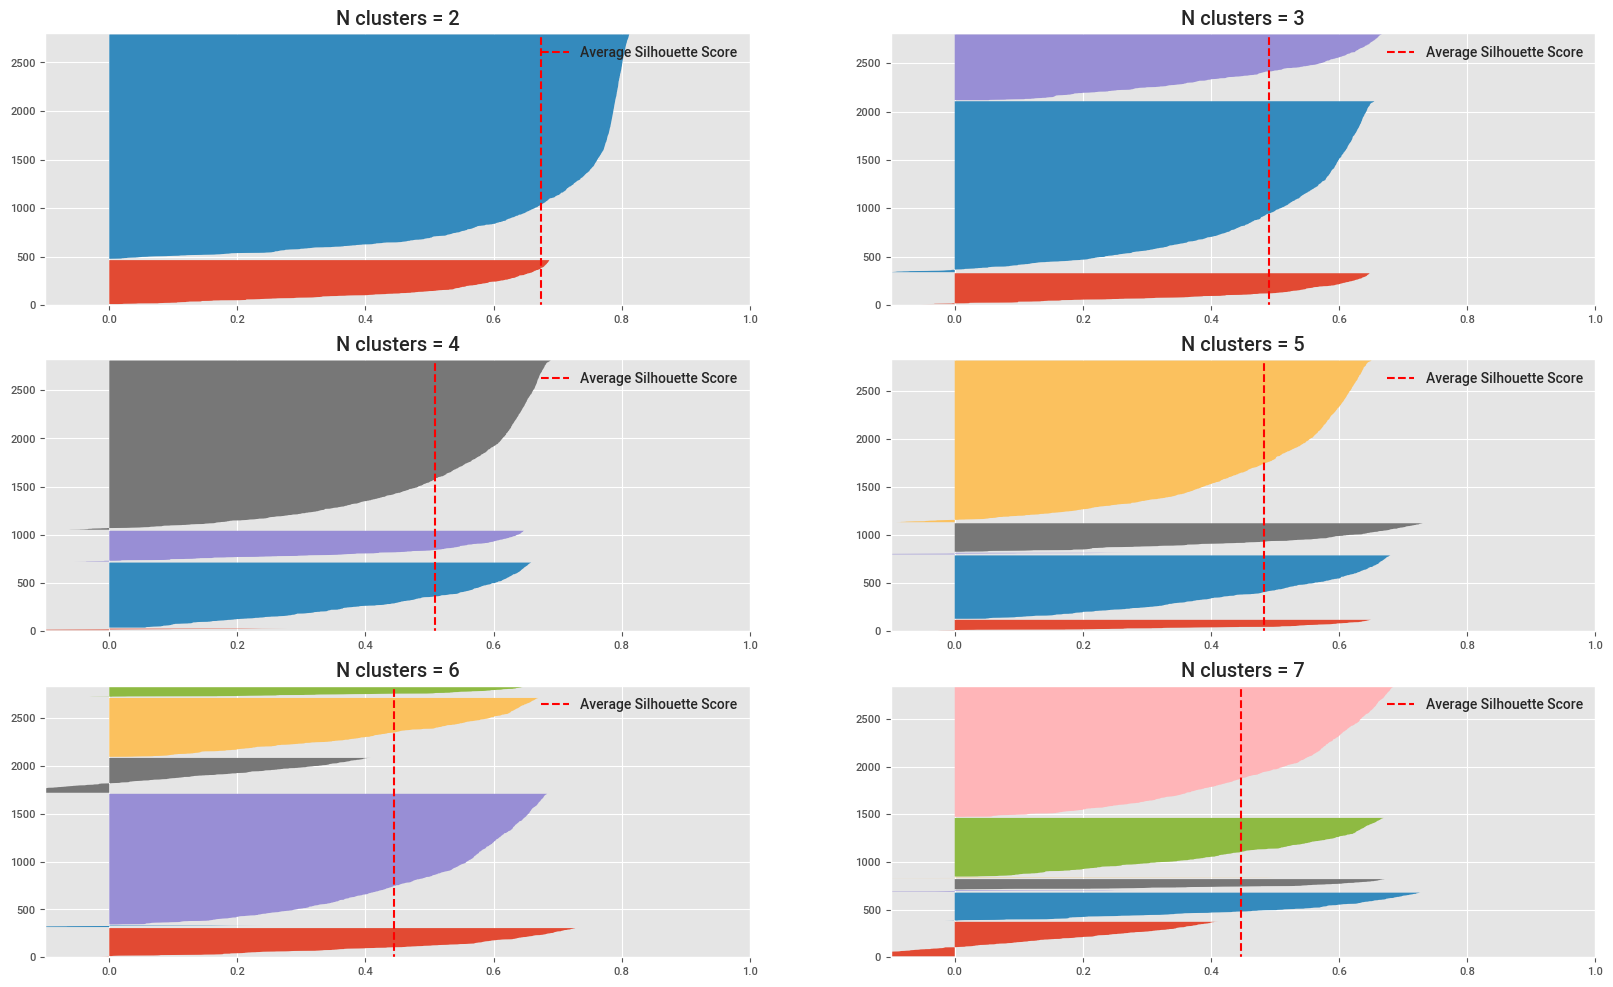

In [116]:
fig, ax = plt.subplots(3, 2, figsize=(20, 12))
n_clusters=[2, 3, 4, 5, 6, 7]
for k in n_clusters:

    # model
    kmean = KMeans(init='random', n_init=10, max_iter=300, n_clusters=k, random_state=42)
    labels = kmean.fit_predict(X)

    q, mod = divmod(k, 2)

    gu.silhouette_analysis(X, labels, ax=ax[q-1, mod], k=k)



## 7.2 GMM

In [91]:
gmm_list = []
comps = [2, 3, 4, 5, 6, 7]
for k in comps:
    gmm = mix.GaussianMixture(n_components=k, random_state=42, covariance_type='tied',)

    try:
        gmm.fit(X)
        labels = gmm.predict(X)

        ss = mt.silhouette_score(X, labels)
    except FloatingPointError:
        ss = np.NaN
    
    gmm_list.append(ss)


Text(0.5, 1.0, 'Elbow Plot')

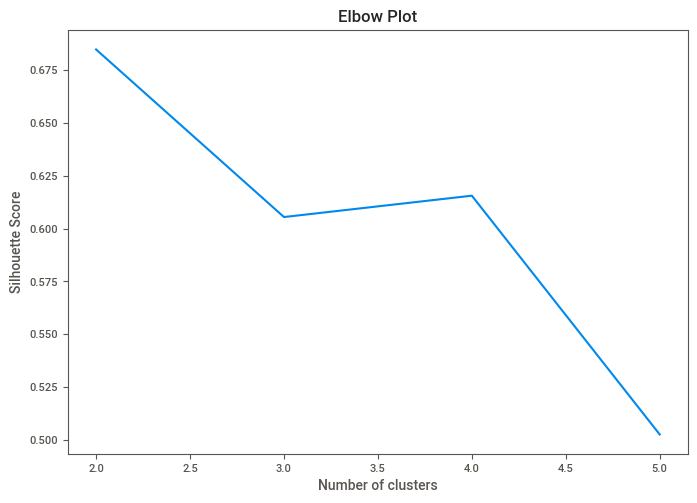

In [92]:
plt.plot(comps, gmm_list)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Elbow Plot')

### 7.2.1 Silhouette Analysis Gaussian Mixture

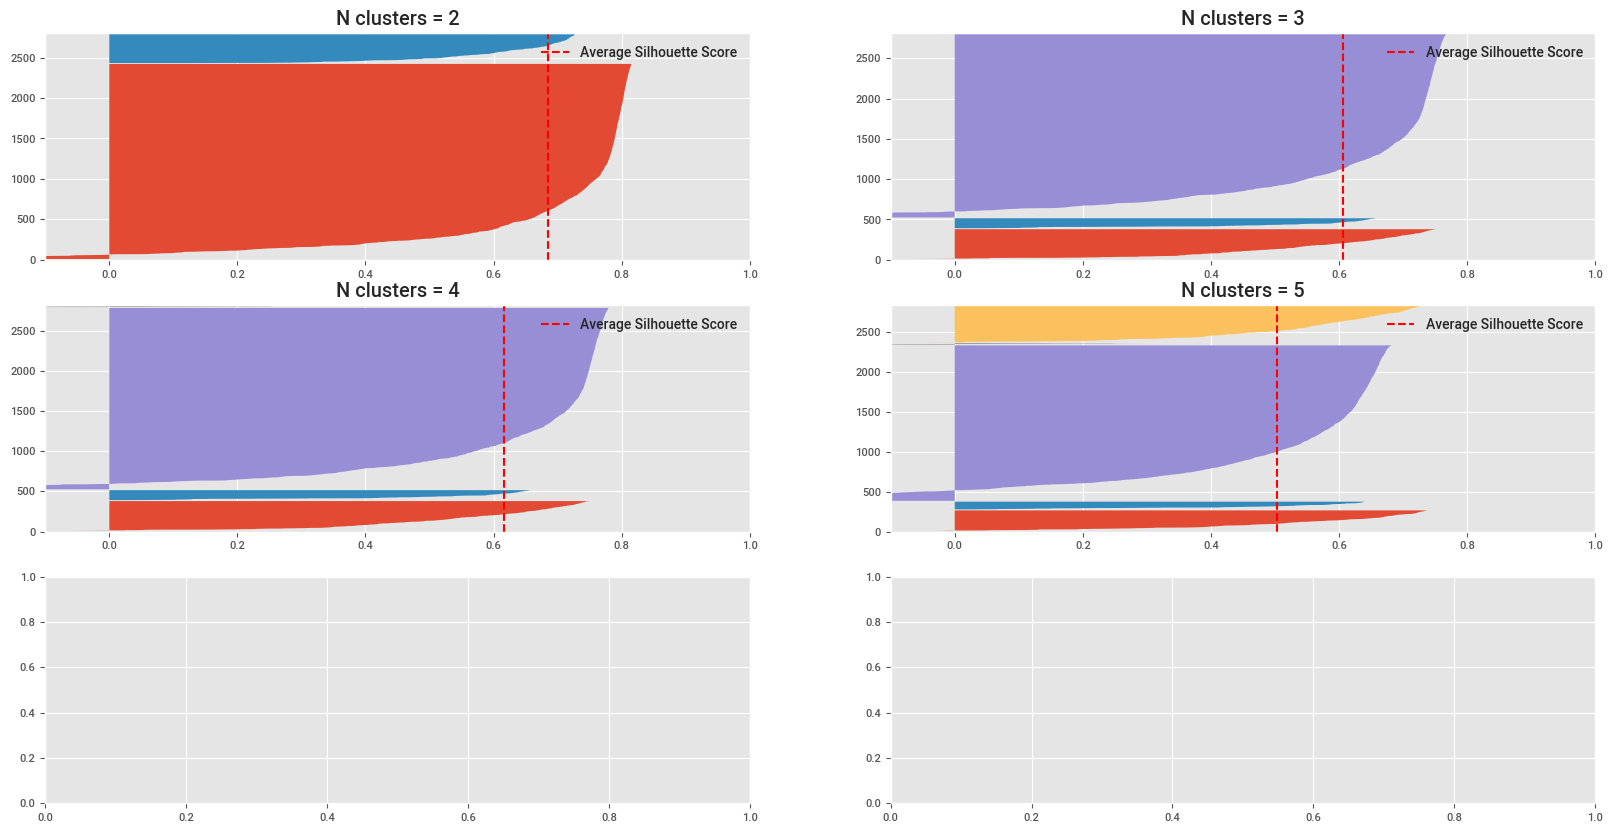

In [114]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10))
n_clusters=[2, 3, 4, 5, 6, 7]
for k in n_clusters:

    # model
    try:
        gmm = mix.GaussianMixture(n_components=k, random_state=42, covariance_type='tied',)
        labels = gmm.fit_predict(X)

        q, mod = divmod(k, 2)
        
        gu.silhouette_analysis(X, labels, ax=ax[q-1, mod], k=k)

    except FloatingPointError:
        pass

## 7.3 Hierarchical Custering

In [93]:
hc_model = linkage(X, 'ward')

In [94]:
#plt.figure(figsize=(20, 8))
#dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8)
#plt.plot()

[]

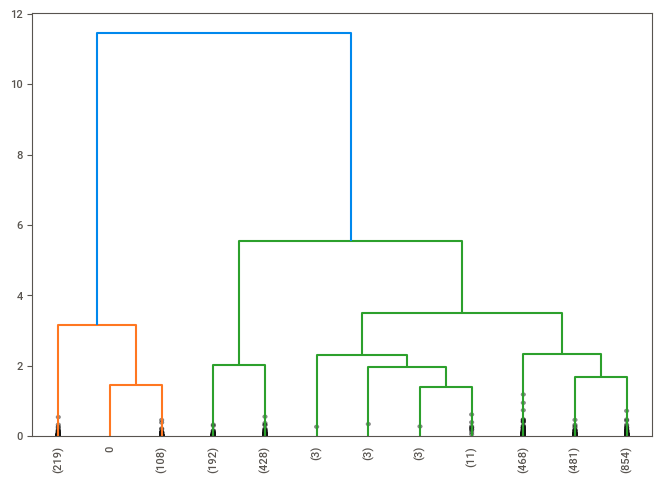

In [95]:
dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
plt.plot()

In [96]:
hc_list = []
for k in clusters:    
    hc_model = linkage(X, 'ward')

    labels = fcluster(hc_model, k, criterion='maxclust')

    sil = mt.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)
    


Text(0.5, 1.0, 'Elbow Plot')

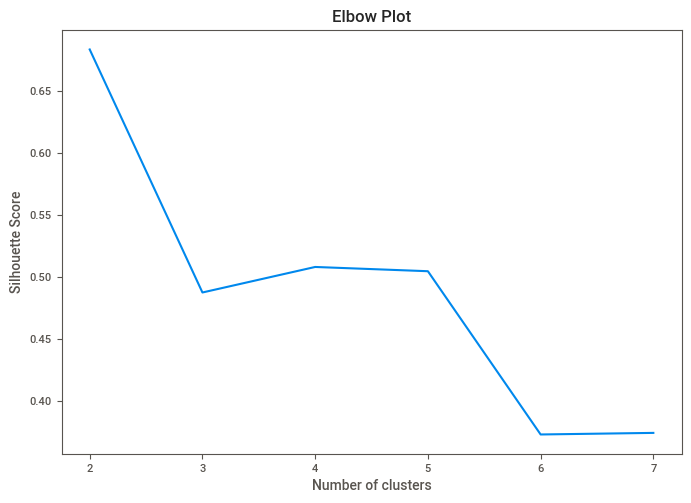

In [97]:
plt.plot(clusters, hc_list)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Elbow Plot')

### 7.3.1 Silhouette Hierarchical CLustering

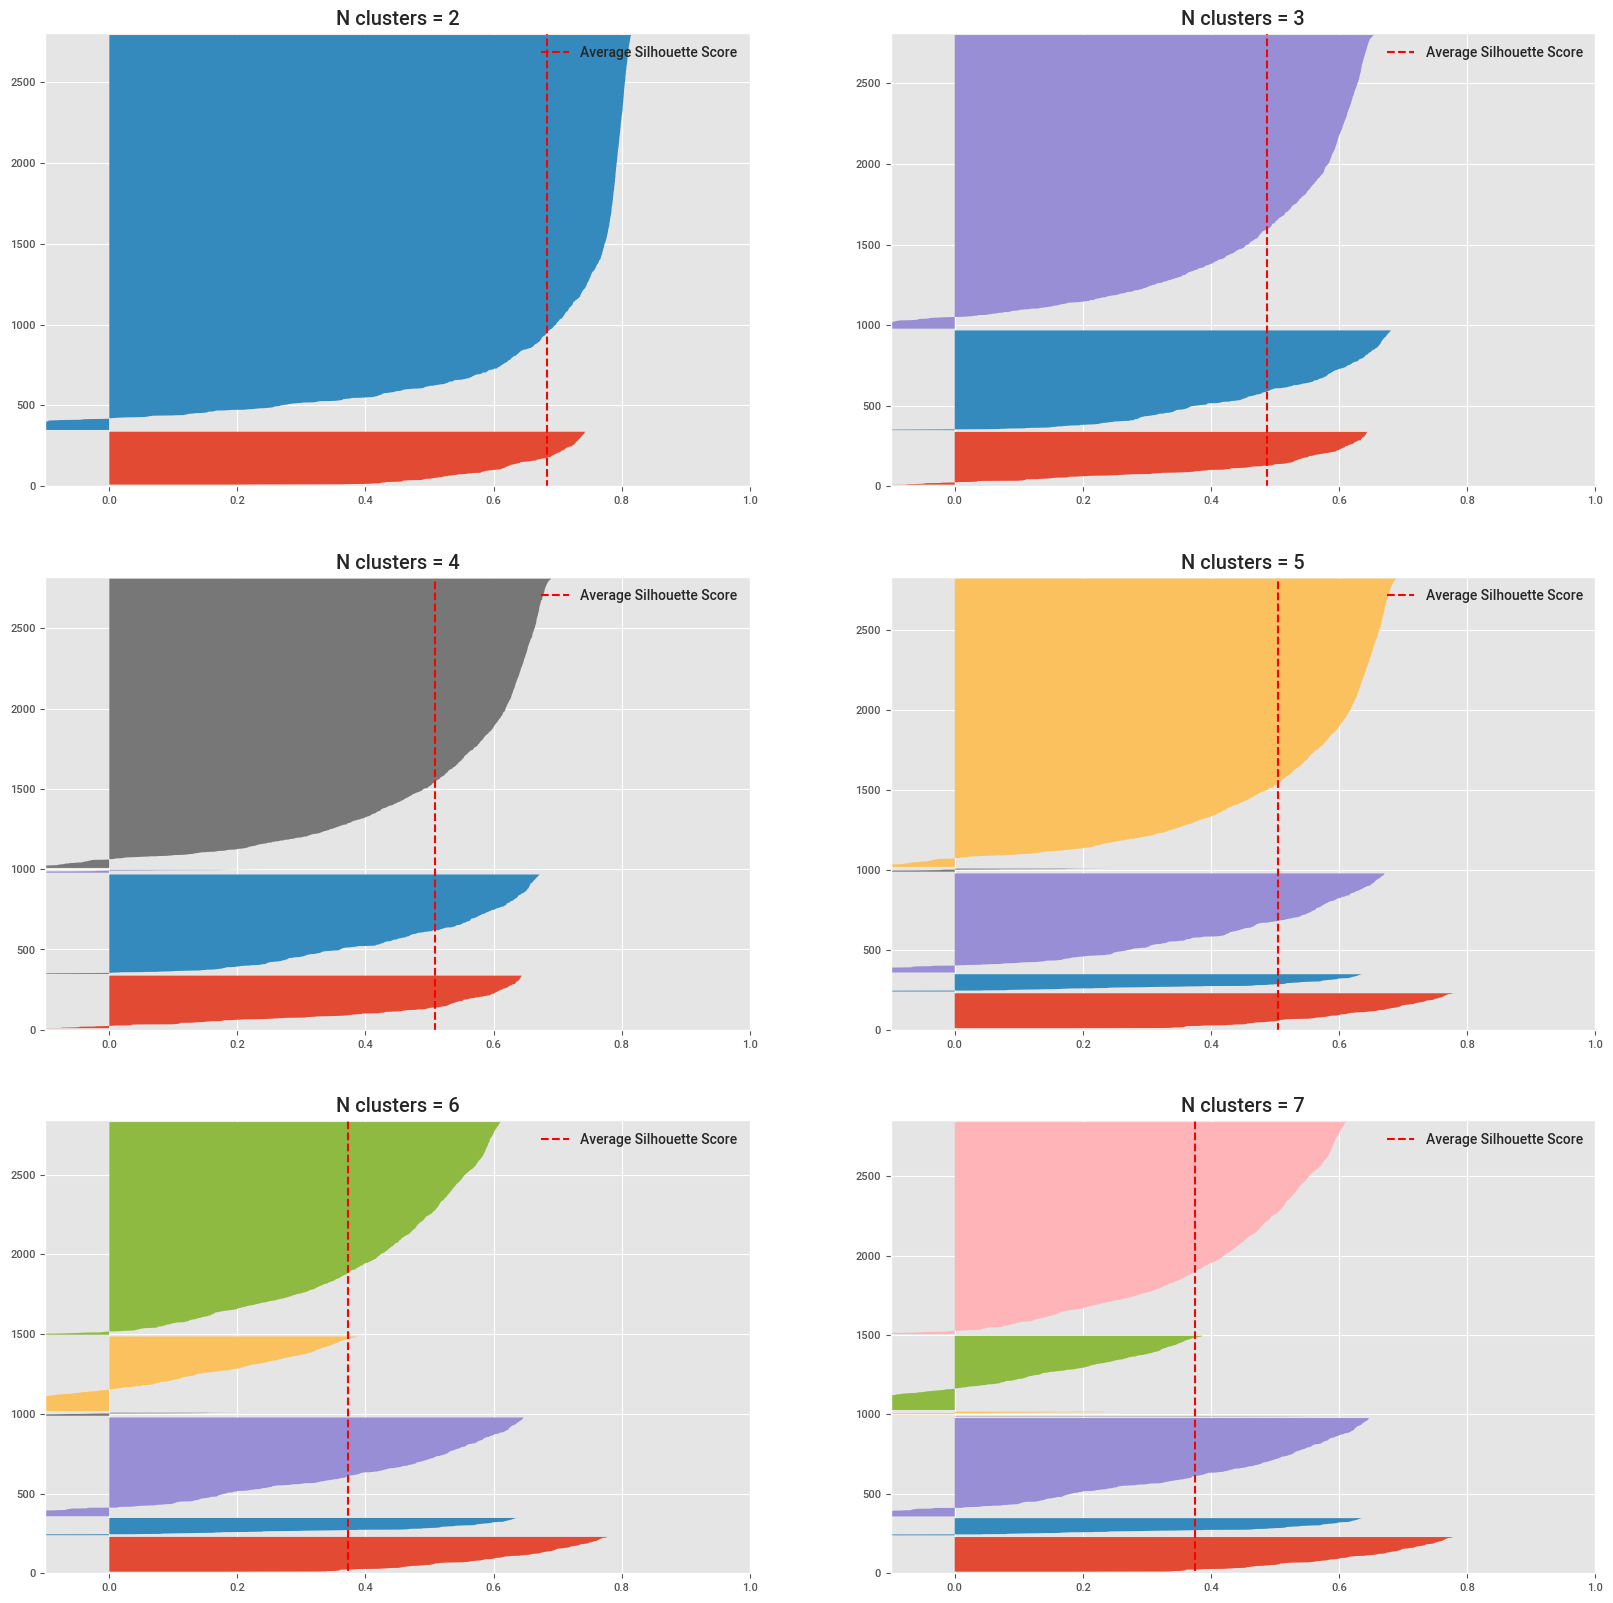

In [110]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
n_clusters=[2, 3, 4, 5, 6, 7]
for k in n_clusters:

    # model
    hc_model = linkage(X, 'ward')
    labels = fcluster(hc_model, k, criterion='maxclust')

    q, mod = divmod(k, 2)

    gu.silhouette_analysis(X, labels, ax=ax[q-1, mod], k=k)



## 7.4 DBSCAN

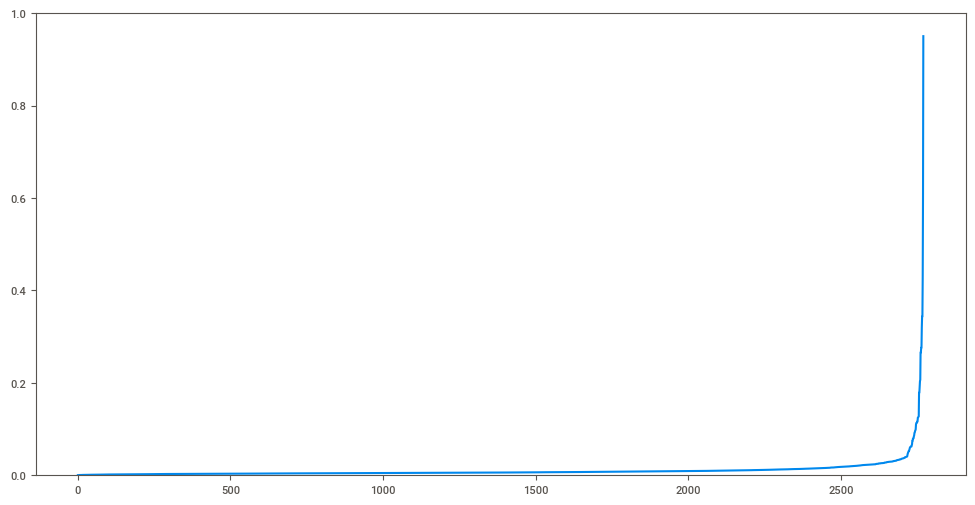

In [98]:
neighbors = NearestNeighbors(n_neighbors=6).fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.ylim(0, 1);

In [99]:
eps_list = np.arange(0.2, 1.1, 0.1)
min_points = np.arange(15, 21)

len(list(product(eps_list, min_points)))

54

In [100]:
eps_ = np.arange(0.2, 1.1, 0.1)
min_points = np.arange(12, 21)
params = list(product(eps_list, min_points))

eps_list = []
min_points_list = []
no_clusters = []
sil_score_list = []

for p in params:

    dbscan = DBSCAN(eps=p[0], min_samples=p[1])
    labels = dbscan.fit_predict(X)

    try:
        sil = mt.silhouette_score(X, labels, metric='euclidean')
    except ValueError:
        sil = 'erro'
        
    eps_list.append(p[0])
    min_points_list.append(p[1])
    no_clusters.append(len(np.unique(labels)))
    sil_score_list.append(sil)

result = pd.DataFrame({'eps': eps_list, 'min_samples': min_points_list, 'no_clusters': no_clusters, 'silhouette_score': sil})

In [101]:
result.query('silhouette_score != "erro"')

Empty DataFrame
Columns: [eps, min_samples, no_clusters, silhouette_score]
Index: []

# Results

In [118]:
df_results = pd.DataFrame({'KMeans': kmeans_list, 'Gaussian Mixture': gmm_list, 'H_cluster': hc_list}, ).T
df_results.columns = n_clusters

In [119]:
df_results.style.highlight_max(color='lightgreen', axis=1)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 8.0. Model Training

## 8.1. K-Means

In [153]:
# model
n_cluster=3
kmeans = KMeans(init='random', n_clusters=n_cluster, n_init=10, max_iter=300, random_state=42)

# model training
labels = kmeans.fit_predict(X)
ss = mt.silhouette_score(X, labels)
wss = kmeans.inertia_

print(f'Silhouette Score: {ss}')
print(f'Within CLuster Sum of Squares: {wss}')

Silhouette Score: 0.49025546289015715
Within CLuster Sum of Squares: 33.9221729040415


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 9.0. Cluster Analysis

## 9.1. Visualization

In [154]:
cluster_df = df_fselect.copy()
cluster_df_sc = df_fselect_sc.copy()
cluster_df['cluster'] = labels
cluster_df_sc['cluster'] = labels

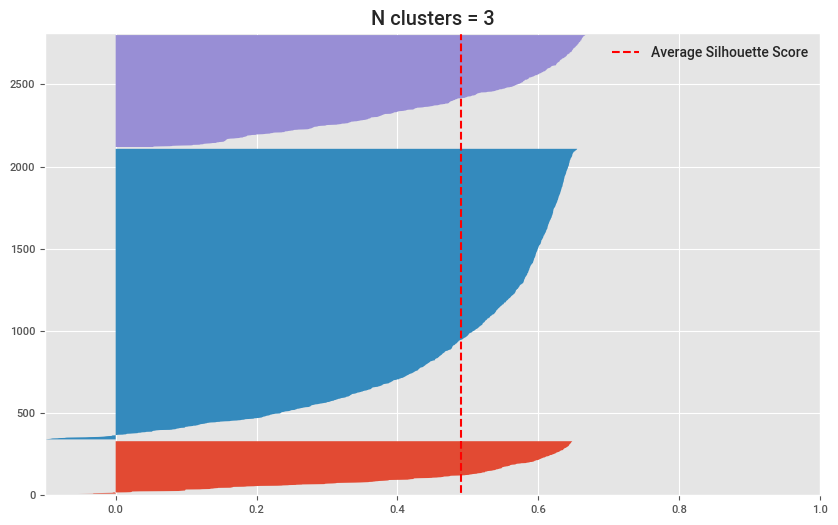

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gu.silhouette_analysis(X, labels, ax, n_cluster)

In [150]:
fig = px.scatter_matrix(cluster_df_sc.drop(columns=['customer_id']), color='cluster')
fig.update_layout(width=1800, height=980, font={'size': 9})
fig.show()

In [135]:
# TSNE
tsne = man.TSNE(random_state=42, perplexity=50)

features_tsne = tsne.fit_transform(X)

#tsne_scaled = man.TSNE(random_state=42)
#
#features_tsne_scaled = tsne.fit_transform(X_scaled)

In [136]:
# UMAP
u_map = um.UMAP(n_neighbors=50, random_state=42)

X_umap = u_map.fit_transform(X)

## TSNE

<AxesSubplot: >

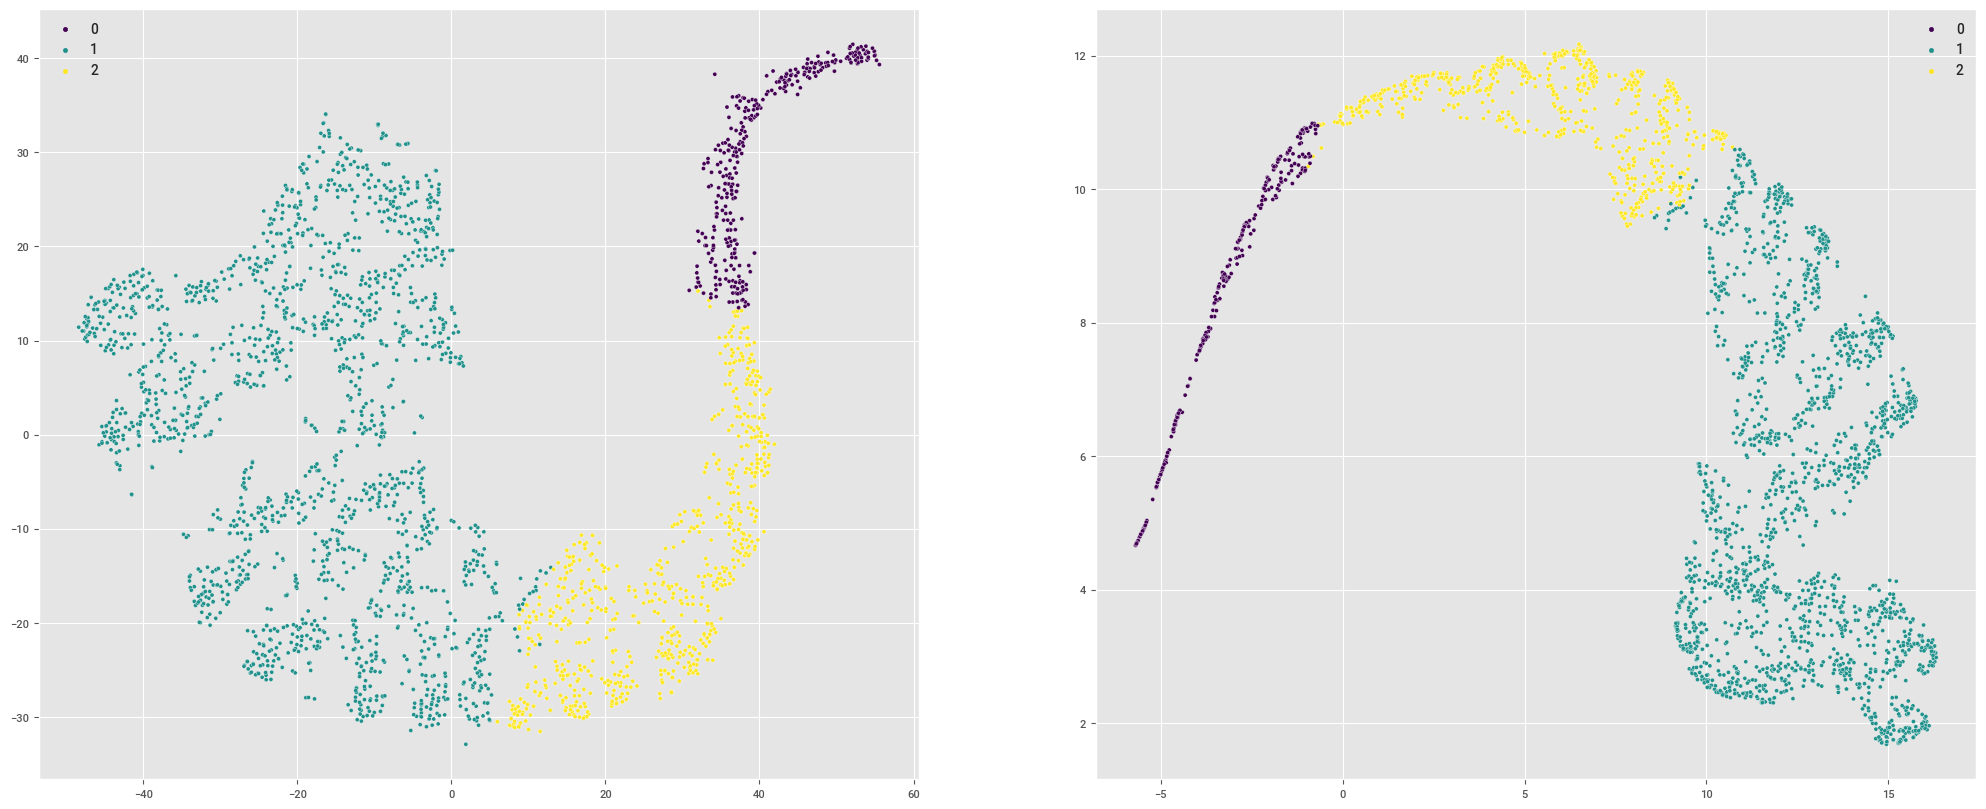

In [137]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='viridis')

<AxesSubplot: >

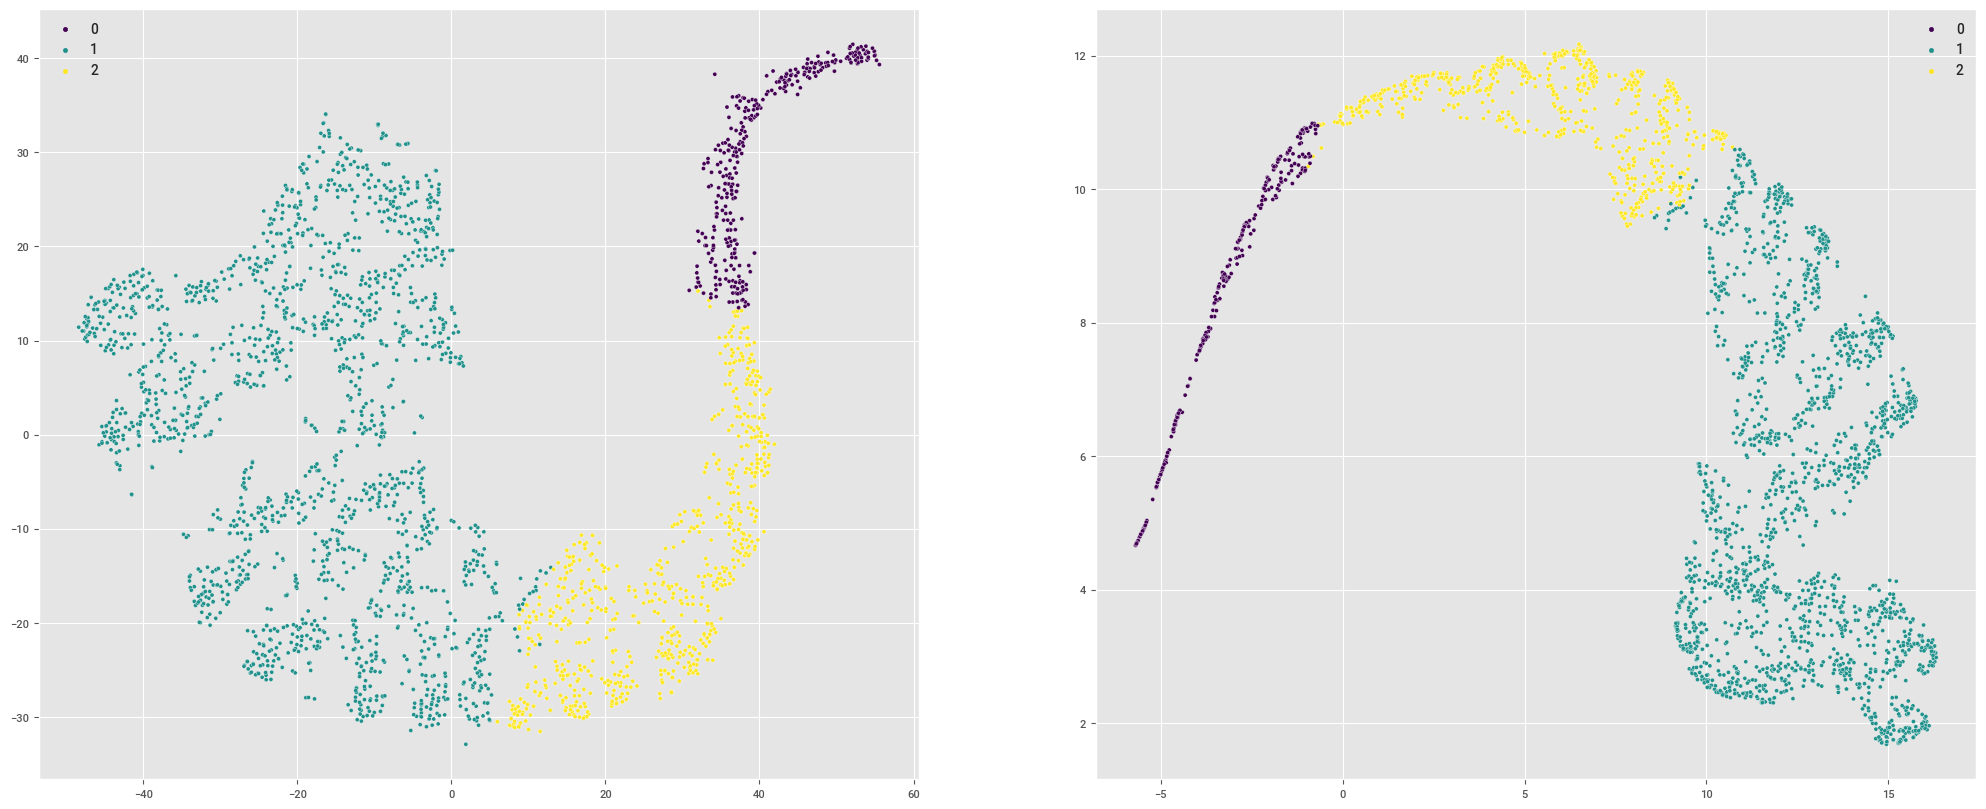

In [138]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='viridis')

In [139]:
#df_fselect['cluster'] = labels_tsne

## 9.2. Clusters Profile

In [151]:
cluster_df.head()

customer_id  recency  frequency  monetary  transactions  product_variety  \
0        17850    372.0  17.000000   5288.63            35             21.0   
1        13047     56.0   0.028302   3089.10            16            105.0   
2        12583      2.0   0.040323   6629.34            17            116.0   
3        13748     95.0   0.017921    948.25             5             24.0   
4        15100    333.0   0.073171    635.10             6              1.0   

   number_of_cancelations  cluster  
0                    40.0        5  
1                    35.0        3  
2                    50.0        4  
3                     0.0        3  
4                    22.0        5

In [155]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index()
prof['percentual'] = (cluster_df.groupby('cluster').count()['customer_id']/cluster_df.shape[0])*100
prof['avg_recency'] = cluster_df.groupby('cluster').mean()['recency']
prof['std_recency'] = cluster_df.groupby('cluster').std()['recency']
prof['avg_frequency'] = cluster_df.groupby('cluster').mean()['frequency']
prof['std_frequency'] = cluster_df.groupby('cluster').std()['frequency']
prof['avg_monetary'] = cluster_df.groupby('cluster').mean()['monetary']
prof['std_monetary'] = cluster_df.groupby('cluster').std()['monetary']
#prof['total_spent'] = cluster_df.groupby('cluster').mean()['total_spent']
#prof['number_of_cancelations'] = cluster_df.groupby('cluster').mean()['number_of_cancelations']

prof['avg_product_variety'] = cluster_df.groupby('cluster').mean()['product_variety']
prof['std_product_variety'] = cluster_df.groupby('cluster').std()['product_variety']
prof

cluster  customer_id  percentual  avg_recency  std_recency  avg_frequency  \
0        0          320   11.548178   214.303125    53.740687       0.119725   
1        1         1769   63.839769    17.492934    13.200596       0.043898   
2        2          682   24.612053    83.533724    26.428184       0.031967   

   std_frequency  avg_monetary  std_monetary  avg_product_variety  \
0       0.956840    890.754062   1483.096211            41.968750   
1       0.104084   3670.826433  12707.357765           102.594121   
2       0.066176   1319.161129   1322.573727            55.183284   

   std_product_variety  
0            41.426813  
1           116.311581  
2            45.014765

<AxesSubplot: xlabel='cluster', ylabel='product_variety'>

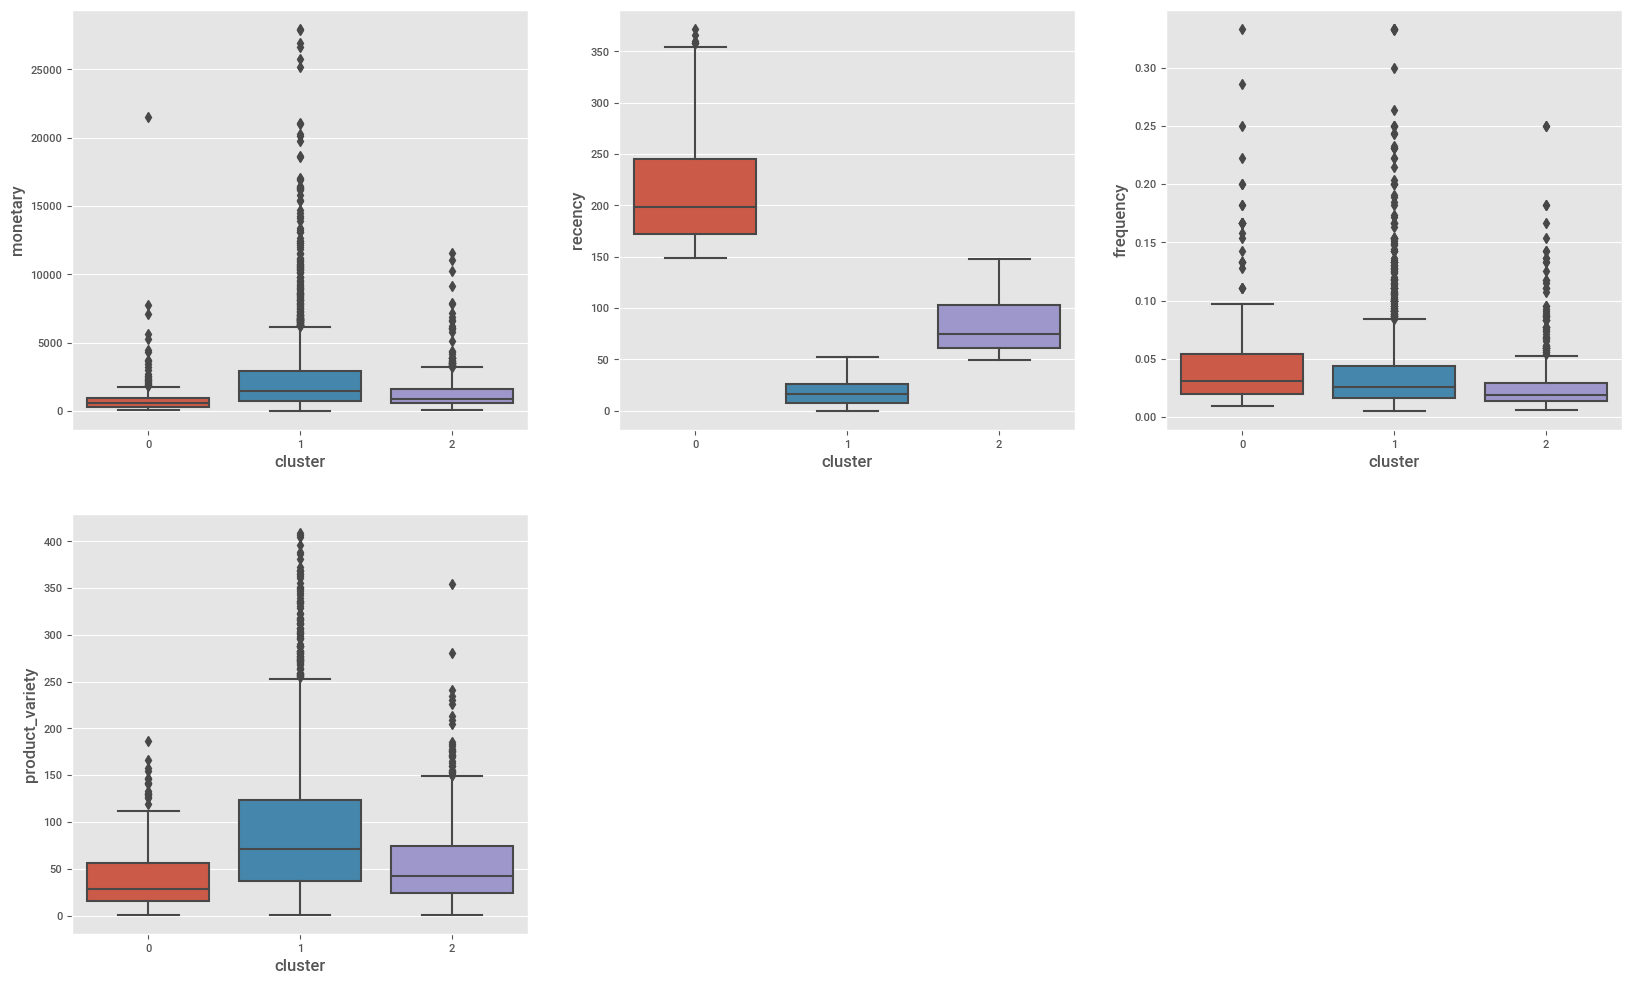

In [159]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
sns.boxplot(x='cluster', y='monetary', data=cluster_df.loc[cluster_df.monetary <= np.quantile(cluster_df.monetary, 0.99)])
plt.subplot(2, 3, 2)
sns.boxplot(x='cluster', y='recency', data=cluster_df)
plt.subplot(2, 3, 3)
sns.boxplot(x='cluster', y='frequency', data=cluster_df.loc[cluster_df.frequency <= np.quantile(cluster_df.frequency, 0.99)])

#plt.subplot(2, 3, 5)
#sns.boxplot(x='cluster', y='avg_unit_price', data=cluster_df.loc[cluster_df.avg_unit_price <= np.quantile(cluster_df.avg_unit_price, 0.99)])
plt.subplot(2, 3, 4)
sns.boxplot(x='cluster', y='product_variety', data=cluster_df.loc[cluster_df.product_variety <= np.quantile(cluster_df.product_variety, 0.99)])

In [209]:
cluster_df.drop(columns=['customer_id', 'latitude', 'longitude']).describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99, 0.997]).T

count         mean          std           min         1%  \
recency          4320.0    91.945602   100.090025  0.000000e+00   1.000000   
frequency        4320.0     4.257639     7.657526  1.000000e+00   1.000000   
monetary         4320.0  1919.924234  8321.216974  1.776357e-15  49.942500   
avg_ticket       4320.0    33.401639   181.637992  1.758769e-17   2.891739   
product_variety  4320.0    62.040278    86.493165  1.000000e+00   1.000000   
avg_quantity     4320.0    20.421175   101.043710  0.000000e+00   1.408235   
avg_unit_price   4320.0     3.466895     7.750726  1.225000e-01   0.692299   
cluster          4320.0     2.510417     1.003528  0.000000e+00   1.000000   

                         5%         10%         20%         50%          80%  \
recency            2.000000    5.000000   12.000000   50.000000   179.000000   
frequency          1.000000    1.000000    1.000000    2.000000     6.000000   
monetary         110.399000  152.994000  243.810000  653.365000  2005.174000   
avg_ticket         4.431502    5.868588    9.071015   16.878442    26.787368   
product_variety    4.000000    7.000000   13.000000   36.000000    93.000000   
avg_quantity       2.264986    3.061458    4.684681    9.631827    16.000000   
avg_unit_price     1.332370    1.651590    2.019266    2.841405     3.993969   
cluster            1.000000    1.000000    2.000000    2.000000     4.000000   

                         90%          95%          99%         99.7%  \
recency           262.100000   311.000000    368.00000    373.000000   
frequency           9.000000    13.000000     30.00000     55.000000   
monetary         3465.770000  5657.141000  17061.55330  53301.082130   
avg_ticket         46.712529    82.266763    325.57920    616.121950   
product_variety   143.100000   205.100000    354.81000    541.172000   
avg_quantity       25.727778    47.631985    200.00000    600.040133   
avg_unit_price      4.949500     6.063969     10.92625     23.567092   
cluster             4.000000     4.000000      4.00000      4.000000   

                        max  
recency             373.000  
frequency           206.000  
monetary         278778.020  
avg_ticket         9904.875  
product_variety    1822.000  
avg_quantity       4300.000  
avg_unit_price      327.225  
cluster               4.000

In [212]:
df_filter.invoice_date.max() - df_filter.invoice_date.min()

Timedelta('373 days 00:00:00')

In [313]:
cluster_df.query('cluster==2').sort_values('monetary', ascending=False)

customer_id  recency  frequency      monetary    avg_ticket  cluster
24923         14646      1.0       72.0  2.787780e+05  1.351979e+02        2
10893         18102      0.0       60.0  2.596573e+05  6.024531e+02        2
9825          17450      8.0       46.0  1.897355e+05  5.580457e+02        2
1399          14911      1.0      199.0  1.330071e+05  2.255888e+01        2
28710         12415     24.0       20.0  1.236382e+05  1.597393e+02        2
...             ...      ...        ...           ...           ...      ...
356845        15657     22.0        1.0  3.000000e+01  3.000000e+01        2
339175        16953     30.0        1.0  2.080000e+01  2.080000e+01        2
136358        16446      0.0        2.0  2.900000e+00  7.250000e-01        2
389544        12558      7.0        1.0  1.065814e-14  4.844610e-16        2
339375        18274     30.0        1.0  1.776357e-15  8.074349e-17        2

[2127 rows x 6 columns]

In [ ]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index()
prof['percentual'] = (cluster_df.groupby('cluster').count()['customer_id']/cluster_df.shape[0])*100
prof['avg_recency'] = cluster_df.groupby('cluster').mean()['recency']
prof['avg_frequency'] = cluster_df.groupby('cluster').mean()['frequency']
#prof['avg_monetary'] = cluster_df.groupby('cluster').mean()['monetary']
prof['total_spent'] = cluster_df.groupby('cluster').mean()['total_spent']
prof['number_of_cancelations'] = cluster_df.groupby('cluster').mean()['number_of_cancelations']
prof['avg_ticket'] = cluster_df.groupby('cluster').mean()['avg_ticket']
prof

cluster  customer_id  percentual  avg_recency  avg_frequency  total_spent  \
0        0          618   14.242913   191.040453       1.873786   603.412930   
1        1          498   11.477299   308.369478       1.349398   392.575221   
2        2         2130   49.089652    18.699061       6.497653  3127.423573   
3        3         1093   25.190136    80.428179       2.622141   988.703744   

   number_of_cancelations  avg_ticket  
0                0.881877   34.513633  
1                0.532129   32.739829  
2                3.136620   29.271794  
3                1.213175   31.824948

In [ ]:
prof

cluster  customer_id  percentual  avg_recency  avg_frequency   avg_monetary
0        0          418    9.633556    26.248804      12.490431    6008.355598
1        1            3    0.069140     3.000000      60.000000  244804.703333
2        2           38    0.875778    13.868421      34.947368   24694.783684
3        3         3865   89.075824   100.321863       2.840103     926.552337
4        4           15    0.345702     7.733333      55.333333   76398.306000

In [130]:
prof

cluster  customer_id  percentual  avg_recency  avg_frequency  \
0        0         4071   93.115279    96.969295       3.641120   
1        1            6    0.137237     7.166667      89.000000   
2        2           28    0.640439     6.178571      57.821429   
3        3          267    6.107045    20.280899      19.528090   

    avg_monetary  avg_ticket  
0     946.696250   25.359654  
1  182181.981667  253.626345  
2   42614.387143  162.862605  
3    8089.028652   62.783157

## 9.3 Report

Cluster 1

    - Number of Customers: 6
    - Percentage of Customers: 0.14%
    - Average Recency: 7.2 
    - Average Frequency: 89
    - Average Monetary: 182,181.98

Cluster 2

    - Number of Customers: 31
    - Percentage of Customers: 0.71%
    - Average Recency: 14 
    - Average Frequency: 53.3
    - Average Monetary: 40,543.52

Cluster 0

    - Number of Customers: 4335
    - Percentage of Customers: 99.15%
    - Average Recency: 92.26 
    - Average Frequency: 4.6
    - Average Monetary: 1,372.58

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 10.0. Deploy to Production